In [1]:
using Arpack
using LinearAlgebra
using LaTeXStrings
using Revise
using PyPlot
using MeshGrid
using JLD2
using PyCall
includet("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/Lattice_setup/lattice_BZ.jl")
includet("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/3P_funcs/patch_methods.jl")
includet("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/3P_funcs/lambda_funcs.jl")

# Helper Functions

In [2]:
function lambda_epsilon_v3(k, n, kappa, gap, vF)
    return (2/n) * vF * sqrt(1 + abs2(gap)) * kappa * sqrt((norm(k)/kappa)^n + abs2(gap))
end
function lambda_ham_v3!(g1, g2, shell_parts, partitions, part_1s, dict, ham, k, lambda, n, gap, vF, V)
    kappa = norm(g2)/sqrt(3)
    # connect all lower order mBZ's to their nn
    for i in 1:length(partitions)
        part_i = partitions[i]
        idex = dict[part_i]
        for j in 1:7
            part_j = part_1s[j]
            gi = part_i[1] * g1 + part_i[2] * g2
            gj = gi .+ part_j[1] * g1 + part_j[2] * g2
            jdex = dict[part_i .+ part_j]
            if part_j != (0, 0)
                val = 1/2 * lambda_ff(V, lambda, k .+ gi, k .+ gj)
                ham[idex, jdex] = val
                ham[jdex, idex] = conj(val)
            end
        end
    end
    # connect outside ring of mBZ's together
    outer_ring = setdiff(shell_parts, partitions)
    for i in 1:length(outer_ring)
        part_i = outer_ring[i]
        idex = dict[part_i]
        for j in 1:7
            part_j = part_1s[j]
            gi = part_i[1] * g1 + part_i[2] * g2
            gj = gi .+ part_j[1] * g1 + part_j[2] * g2
            if (part_i .+ part_j) in outer_ring && part_j != (0, 0)
                jdex = dict[part_i .+ part_j]
                val = 1/2 * lambda_ff(V, lambda, k .+ gi, k .+ gj)
                ham[idex, jdex] = val
                ham[jdex, idex] = conj(val)
            end
        end
    end
    # add in kinetic terms
    for i in 1:length(shell_parts)
        part = shell_parts[i]
        idex = dict[part]
        gi = part[1] * g1 + part[2] * g2
        ham[idex, idex] = lambda_epsilon_v3(gi .+ k, n, kappa, gap, vF)
    end
    return ham
end
function lambda_ham_v3(k, lambda, n, gap, vF, kappa, V, shells)
    mBZ_count = num_mBZ(shells)
    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    shell_parts = sgn_parts(shells)
    partitions = sgn_parts(shells - 1)
    part_1s = sgn_parts(1)
    dict = part_dict(shells)
    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]
    lambda_ham_v3!(g1, g2, shell_parts, partitions, part_1s, dict, ham, k, lambda, n, gap, vF, V)
end

lambda_ham_v3 (generic function with 1 method)

In [3]:
function lambda_mBZ_bc_v3(k, lambda, n, gap, vF, kappa, V, shells, index, spacing)
    num_vertices = 4

    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]

    mBZ_count = num_mBZ(shells)
    shell_parts = sgn_parts(shells)
    partitions = sgn_parts(shells - 1)
    part_1s = sgn_parts(1)
    dict = part_dict(shells)

    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    
    spinors = Array{ComplexF64}(undef, num_vertices, mBZ_count, 2)
    grounds = Array{ComplexF64}(undef, num_vertices, mBZ_count)

    plaq_area = area(spacing * sqrt(2), num_vertices)
    lambda_mBZ_bc_v3!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, k, 
    lambda, n, gap, vF, kappa, V, shells, index, spacing)
end
function lambda_mBZ_bc_v3!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, k, lambda, n, gap, vF, kappa, V, shells, index, spacing)
    for j in 1:num_vertices
        x_new = k[1] + spacing * cos(2 * pi * (j - 1) / num_vertices)
        y_new = k[2] + spacing * sin(2 * pi * (j - 1) / num_vertices)
        ham = lambda_ham_v3!(g1, g2, shell_parts, partitions, part_1s, dict, ham, [x_new, y_new], lambda, n, gap, vF, V)
        grounds[j, :] = gauge_fix(normalize(eigvecs(Hermitian(ham))[:, index]))
        for m in 1:length(shell_parts)
            momentum = g1 * shell_parts[m][1] + g2 * shell_parts[m][2] + [x_new, y_new]
            spinors[j, m, :] = lambda_spinor(lambda, momentum)
        end
    end
    P = 1
    for j in 1:num_vertices
        if j < num_vertices
            temp = spinor_inner(grounds[j, :], grounds[j + 1, :], spinors[j, :, :], spinors[j + 1, :, :])
            P *= temp / abs(temp)
        else
            temp = spinor_inner(grounds[j, :], grounds[1, :], spinors[j, :, :], spinors[1, :, :])
            P *= temp / abs(temp)
        end
    end
    if abs(imag(P)) < 10^(-16)
        return -(angle(real(P))) / plaq_area
    else
        return -angle(P) / plaq_area
    end
end
function grid_bc_v3(grid, lambda, n, gap, vF, kappa, V, shells, index, spacing)
    num_vertices = 4

    mBZ_count = num_mBZ(shells)
    shell_parts = sgn_parts(shells)
    partitions = sgn_parts(shells - 1)
    part_1s = sgn_parts(1)
    dict = part_dict(shells)

    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    spinors = Array{ComplexF64}(undef, num_vertices, mBZ_count, 2)
    grounds = Array{ComplexF64}(undef, num_vertices, mBZ_count)
    plaq_area = area(spacing * sqrt(2), num_vertices)

    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]

    gi = zeros(2)
    gj = zeros(2)

    berry_list = Array{Float64}(undef, size(grid, 1))

    for i in 1:size(grid, 1)
        berry_list[i] = lambda_mBZ_bc_v3!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, 
        grid[i, :], lambda, n, gap, vF, kappa, V, shells, index, spacing)
    end
    return berry_list
end
function lambda_mBZ_phase_v3!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, k, lambda, n, gap, vF, kappa, V, shells, index, spacing)
    for j in 1:num_vertices
        x_new = k[1] + spacing * cos(2 * pi * (j - 1) / num_vertices)
        y_new = k[2] + spacing * sin(2 * pi * (j - 1) / num_vertices)
        ham = lambda_ham_v3!(g1, g2, shell_parts, partitions, part_1s, dict, ham, [x_new, y_new], lambda, n, gap, vF, V)
        grounds[j, :] = gauge_fix(normalize(eigvecs(Hermitian(ham))[:, index]))
        for m in 1:length(shell_parts)
            momentum = g1 * shell_parts[m][1] + g2 * shell_parts[m][2] + [x_new, y_new]
            spinors[j, m, :] = lambda_spinor(lambda, momentum)
        end
    end
    P = 0
    # P = 1
    for j in 1:num_vertices
        if j < num_vertices
            temp = angle(spinor_inner(grounds[j, :], grounds[j + 1, :], spinors[j, :, :], spinors[j + 1, :, :]))
            # P *= temp / abs(temp)
            P += temp
        else
            temp = angle(spinor_inner(grounds[j, :], grounds[1, :], spinors[j, :, :], spinors[1, :, :]))
            P += temp
            # P *= temp / abs(temp)
        end
    end
    return P
    # if abs(imag(P)) < 10^(-16)
    #     return -(angle(real(P))) / plaq_area
    # else
    #     return -angle(P) / plaq_area
    # end
end
function grid_phase_v3(grid, lambda, n, gap, vF, kappa, V, shells, index, spacing)
    num_vertices = 15
    mBZ_count = num_mBZ(shells)
    shell_parts = sgn_parts(shells)
    partitions = sgn_parts(shells - 1)
    part_1s = sgn_parts(1)
    dict = part_dict(shells)

    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    spinors = Array{ComplexF64}(undef, num_vertices, mBZ_count, 2)
    grounds = Array{ComplexF64}(undef, num_vertices, mBZ_count)
    plaq_area = area(spacing * sqrt(2), num_vertices)

    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]

    gi = zeros(2)
    gj = zeros(2)

    berry_list = Array{Float64}(undef, size(grid, 1))

    for i in 1:size(grid, 1)
        berry_list[i] = lambda_mBZ_phase_v3!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, 
        grid[i, :], lambda, n, gap, vF, kappa, V, shells, index, spacing)
    end
    return berry_list
end

grid_phase_v3 (generic function with 1 method)

# Energy plotting functions

In [4]:
function plot_gap_lambda_v3(q, n, gap_list, vF, kappa, V, shells, llm, ulm)
    lambda_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(lambda_list), length(gap_list))
    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        # q1 = kappa * [1, 0] + q
        for j in 1:length(gap_list)
            gap = gap_list[j]
            ham = lambda_ham_v3(q, lambda, n, gap, vF, kappa, V, shells)
            vals = eigvals(Hermitian(ham))
            gaps[i, j] = log10(vals[2] - vals[1])
        end
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$\lambda$")
    axs.set_ylabel(L"$\log|\epsilon_0 - \epsilon_1|$")
    axs.set_title(L"$\log|\epsilon_0 - \epsilon_1|_{n} \text{ vs } \lambda$")
    for j in 1:length(gap_list)
        d = round(gap_list[j], sigdigits=2)
        axs.plot(lambda_list, gaps[:, j], label = raw"$d = $" * "$d")
    end
    axs.legend()
    fig
end
function plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, spacing, ky, llm, ulm)
    n_pts = 10^2

    kx_list = range(llm, ulm, n_pts)

    energies = Array{Float64}(undef, n_pts, 3)

    for j in 1:(n_pts)
        k = [kx_list[j], ky]
        ham = lambda_ham_v3(k, lambda, n, gap, vF, kappa, V, shells)
        energies[j, 1] = eigvals(Hermitian(ham))[1]
        energies[j, 2] = eigvals(Hermitian(ham))[2]
        energies[j, 3] = eigvals(Hermitian(ham))[3]
    end

    fig, axs = plt.subplots(1,figsize=(12, 8))
    axs.set_xlabel(L"$k_x$")
    axs.set_ylabel(L"$\epsilon$")
    axs.plot(kx_list, energies[:, 1], label = L"\epsilon_0")
    axs.plot(kx_list, energies[:, 2], label = L"\epsilon_1")
    # axs.plot(kx_list, energies[:, 3], label = L"\epsilon_2")
    axs.legend()
    fig.tight_layout()
    
    fig
end
function plot_energy_ang_v3(lambda, n, gap, vF, kappa, V, shells, spacing, mag)
    n_pts = 10^2

    ang_list = range(-pi, pi, n_pts)

    energies = Array{Float64}(undef, n_pts, 3)

    for j in 1:(n_pts)
        k = [kappa, 0] + mag * [cos(ang_list[j]), sin(ang_list[j])]
        ham = lambda_ham_v3(k, lambda, n, gap, vF, kappa, V, shells)
        energies[j, 1] = eigvals(Hermitian(ham))[1]
        energies[j, 2] = eigvals(Hermitian(ham))[2]
        energies[j, 3] = eigvals(Hermitian(ham))[3]
    end

    fig, axs = plt.subplots(1,figsize=(12, 8))
    axs.set_xlabel(L"$\theta/ \pi$")
    axs.set_ylabel(L"$\epsilon$")
    axs.plot(ang_list/pi, energies[:, 1], label = L"\epsilon_0")
    #axs.plot(ang_list/pi, energies[:, 2], label = L"\epsilon_1")
    #axs.plot(ang_list/pi, energies[:, 3], label = L"\epsilon_2")
    axs.legend()
    fig.tight_layout()
    
    fig
end
function plot_vF_crit(lambda, n, gap, kappa, V, shells, spacing, mag, index, llm, ulm)
    n_pts = 10^2
    vF_list = range(llm, ulm, n_pts)
    energies = Array{Float64}(undef, n_pts)
    for j in 1:n_pts
        vF = vF_list[j]
        q1 = [kappa, 0] + mag * [1, 0]
        q2 = [kappa, 0] + mag * [-1, 0]
        ham1 = lambda_ham_v3(q1, lambda, n, gap, vF, kappa, V, shells)
        eg1 = eigvals(Hermitian(ham1))[index]
        ham2 = lambda_ham_v3(q2, lambda, n, gap, vF, kappa, V, shells)
        eg2 = eigvals(Hermitian(ham2))[index]
        energies[j] = abs(eg2 - eg1)
    end
    fig, axs = plt.subplots(1,figsize=(12, 8))
    axs.set_xlabel(L"$v_F$")
    axs.set_ylabel(L"$d \epsilon$")
    axs.plot(vF_list, energies)
    #axs.plot(ang_list/pi, energies[:, 2], label = L"\epsilon_1")
    #axs.plot(ang_list/pi, energies[:, 3], label = L"\epsilon_2")
    axs.legend()
    fig.tight_layout()
    
    fig
end     
function energy_slope_v3(lambda, n, gap, vF, kappa, V, shells, ky, kx, index, dmu)

    ham0 = lambda_ham_v3([kx, ky], lambda, n, gap, vF, kappa, V, shells)
    eg0 = eigvals(Hermitian(ham0))[index]

    ham1 = lambda_ham_v3([kx + dmu, ky], lambda, n, gap, vF, kappa, V, shells)
    eg1 = eigvals(Hermitian(ham1))[index]

    return (eg1 - eg0) / dmu
end
function plot_energy_slopes_v3(lambda, n, gap, vF, kappa, V, shells, spacing, ky, dmu, llm, ulm)
    n_pts = 10^2

    kx_list = range(llm, ulm, n_pts)

    slopes = Array{Float64}(undef, n_pts, 3)

    for j in 1:(n_pts)
        kx = kx_list[j]
        slopes[j, 1] = energy_slope_v3(lambda, n, gap, vF, kappa, V, shells, ky, kx, 1, dmu)
        slopes[j, 2] = energy_slope_v3(lambda, n, gap, vF, kappa, V, shells, ky, kx, 2, dmu)
        slopes[j, 3] = energy_slope_v3(lambda, n, gap, vF, kappa, V, shells, ky, kx, 3, dmu)
    end

    fig, axs = plt.subplots(1,figsize=(12, 8))
    axs.set_xlabel(L"$k_x$")
    axs.set_ylabel(L"$\frac{d\epsilon}{d k_x}$")
    axs.plot(kx_list, slopes[:, 1], label = L"0")
    axs.plot(kx_list, slopes[:, 2], label = L"1")
    #axs.plot(kx_list, slopes[:, 3], label = L"2")
    axs.legend()
    fig.tight_layout()
    
    fig
end
function plot_gap_vF_v3(q, n, gap_list, lambda, kappa, V, shells, llm, ulm)
    vF_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(vF_list), length(gap_list))
    for i in 1:length(vF_list)
        vF = vF_list[i]
        # q1 = kappa * [1, 0]
        for j in 1:length(gap_list)
            gap = gap_list[j]
            ham = lambda_ham_v3(q, lambda, n, gap, vF, kappa, V, shells)
            vals = eigvals(Hermitian(ham))
            gaps[i, j] = log10(vals[2] - vals[1])
        end
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$v_F$")
    axs.set_ylabel(L"$\log|\epsilon_0 - \epsilon_1|$")
    axs.set_title(L"$\log|\epsilon_0 - \epsilon_1|_{n} \text{ vs } v_F$")
    for j in 1:length(gap_list)
        d = round(gap_list[j], sigdigits=2)
        axs.plot(vF_list, gaps[:, j], label = raw"$d = $" * "$d")
    end
    axs.legend()
    fig
end

plot_gap_vF_v3 (generic function with 1 method)

# Berry curvature plotting functions

In [5]:
function plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, spacing, shift)
    n_pts = 10^2
    
    kx_list = range(kappa - shift, kappa + shift, n_pts)
    ky_list = shift * range(-1, 1, n_pts)
    grid = mesh_grid(kx_list, ky_list, Float64)

    # k_list = range(-kappa, kappa, n_pts)
    # grid = mesh_grid(k_list, k_list, Float64)


    bc_list = grid_bc_v3(grid, lambda, n, gap, vF, kappa, V, shells, index, spacing)

    grid_new = reshape(grid, (n_pts, n_pts, 2))
    bc_list_new = reshape(bc_list, (n_pts, n_pts))

    bc_min = minimum(bc_list_new)
    bc_max = maximum(bc_list_new)
    bc_abs = maximum(abs.([bc_min, bc_max]))

    figure()
    xlabel(L"k_x")
    ylabel(L"k_y")
    title(L"\Omega(k_x, k_y) \text{ vs } (k_x, k_y)")
    pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], bc_list_new, cmap="RdBu")
    colorbar()
    display(gcf())
end
function plot_ang_bc_v3(gap, vF, n, lambda, kappa, V, shells, index, spacing, k_mag)
    n_pts = 10^2
    
    bc_list = Array{Float64}(undef, n_pts)

    ang_list = range(-pi, pi, n_pts)
    
    for j in 1:length(ang_list)
        point = reshape([kappa, 0] + k_mag * [cos(ang_list[j]), sin(ang_list[j])], (1, 2))
        bc_list[j] = grid_bc_v3(point, lambda, n, gap, vF, kappa, V, shells, index, spacing)[1]
    end

    fig, axs = plt.subplots(1,1,figsize=(15, 6))
    axs.plot(ang_list/pi, bc_list)
    axs.set_xlabel(L"$\text{arg}(k)/ \pi$")
    axs.set_ylabel(L"$\Omega$")

    fig.tight_layout()
    fig
end
function plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, spacing, scale)
    n_pts = 10^2
    
    # kx_list = range(kappa - shift, kappa + shift, n_pts)
    # ky_list = shift * range(-1, 1, n_pts)
    # grid = mesh_grid(kx_list, ky_list, Float64)

    k_list = scale * range(-kappa, kappa, n_pts)
    grid = mesh_grid(k_list, k_list, Float64)


    bc_list = grid_bc_v3(grid, lambda, n, gap, vF, kappa, V, shells, index, spacing) / pi

    grid_new = reshape(grid, (n_pts, n_pts, 2))
    bc_list_new = reshape(bc_list, (n_pts, n_pts))

    bc_min = minimum(bc_list_new)
    bc_max = maximum(bc_list_new)
    bc_abs = maximum(abs.([bc_min, bc_max]))

    fig, axs = plt.subplots(1,1,figsize=(8, 9))
    axs.set_xlabel(L"q_x", fontsize=16)
    axs.set_ylabel(L"q_y", fontsize=16)
    xticks = [1]
    xlabels = [L"0"]
    # axs.set_xticks(xticks, labels=xlabels)
    yticks = [0]
    ylabels = [L"0"]
    # axs.set_yticks(yticks, labels=ylabels)

    #axs.yaxis.set_label_coords(-0.15, 0.47)
    # title(L"\Omega(k_x, k_y) \text{ vs } (k_x, k_y)")
    berry = pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], bc_list_new, cmap="RdBu")
    cbar = fig.colorbar(berry, orientation="horizontal", location="top")
    # cbar.set_ticks([-30000, -15000, 0])
    # cbar.set_ticklabels([L"-3 * 10^4 \pi", L"-1.5 * 10^4 \pi", "0"])
    fig
end

plotter_bc_v3 (generic function with 1 method)

# Symmetry Indicator Functions

In [18]:
function tol_ang(z::Complex; tol=1e-8)
    theta = angle(z) 
    if abs(abs(theta) - pi) < tol
        return pi
    else
        return theta
    end
end
function C2_ev(n, gap, lambda, vF, kappa, V, shells)
    q1 = kappa * [-3/4, sqrt(3)/4]
    parts = part_dict(shells)
    rel_indices = [parts[(1, 0)], parts[(-1, 0)]]

    ham1 = lambda_ham_v3(q1, lambda, n, gap, vF, kappa, V, shells)
    vec1 = gauge_fix(normalize(eigvecs(ham1)[:, 1]))
    vector = vec1[rel_indices]

    return round(tol_ang(vector[1]/vector[2])/pi)
end
function plot_C2_phase_vF(n, gap, lambda, kappa, V, shells, llm, ulm)
    vF_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(vF_list))
    for i in 1:length(vF_list)
        vF = vF_list[i]
        gaps[i] = C2_ev(n, gap, lambda, vF, kappa, V, shells)
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$v_F$")
    axs.set_ylabel(L"$\ell_{2}$")
    axs.set_title(L"$\ell_2 \text{ vs } v_F$")
    axs.plot(vF_list, gaps)
    fig
end
function plot_C2_phase_lambda(n, gap, vF, kappa, V, shells, llm, ulm)
    lambda_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(lambda_list))
    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        gaps[i] = C2_ev(n, gap, lambda, vF, kappa, V, shells)
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$\lambda$")
    axs.set_ylabel(L"$\ell_{2}$")
    axs.set_title(L"$\ell_2 \text{ vs } \lambda$")
    axs.plot(lambda_list, gaps)
    fig
end
function C3_ev(n, gap, lambda, vF, kappa, V, shells)
    parts = part_dict(shells)

    q1 = kappa * [cos(2*pi/3), sin(2*pi/3)]
    rel_indices = [parts[(1, -1)], parts[(-1, 1)]]
    ham1 = lambda_ham_v3(q1, lambda, n, gap, vF, kappa, V, shells)
    vec1 = gauge_fix(normalize(eigvecs(ham1)[:, 1]))
    vector = vec1[rel_indices]

    ang_kap = round(tol_ang(vector[1]/vector[2])/(2*pi/3))

    q2 = kappa * [0, 0]
    rel_indices = [parts[(1, -1)], parts[(-1, 1)]]
    ham2 = lambda_ham_v3(q2, lambda, n, gap, vF, kappa, V, shells)
    vec2 = gauge_fix(normalize(eigvecs(ham2)[:, 1]))
    vector = vec2[rel_indices]

    ang_og = round(tol_ang(vector[1]/vector[2])/(2*pi/3))

    return ang_kap + ang_og
end
function plot_C3_phase_vF(n, gap, lambda, kappa, V, shells, llm, ulm)
    vF_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(vF_list))
    for i in 1:length(vF_list)
        vF = vF_list[i]
        gaps[i] = C3_ev(n, gap, lambda, vF, kappa, V, shells)
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$v_F$")
    axs.set_ylabel(L"$\ell_{3}$")
    axs.set_title(L"$\ell_3 \text{ vs } v_F$")
    axs.plot(vF_list, gaps)
    fig
end
function plot_C3_phase_lambda(n, gap, vF, kappa, V, shells, llm, ulm)
    lambda_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(lambda_list))
    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        gaps[i] = C3_ev(n, gap, lambda, vF, kappa, V, shells)
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$\lambda$")
    axs.set_ylabel(L"$\ell_{3}$")
    axs.set_title(L"$\ell_3 \text{ vs } \lambda$")
    axs.plot(lambda_list, gaps)
    fig
end
function chern_mod_6(c2, c3)
    if c2 == 0
        if c3 == -1
            return 2
        elseif c3 == 0
            return 0
        elseif c3 == 1
            return 4
        end
    elseif c2 == 1
        if c3 == -1
            return 5
        elseif c3 == 0
            return 3
        elseif c3 == 1
            return 1
        end
    end
end

chern_mod_6 (generic function with 1 method)

# Critical Data $(2n = 22)$

In [54]:
# set the relevant parameters
q = [0, 0]
n = 22
gap_list = [10]
vF = 0.7457
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.9998922
ulm = 0.9998923
plot_gap_lambda_v3(q, n, gap_list, vF, kappa, V, shells, llm, ulm)

In [ ]:
# set the relevant parameters
q = [0.5, 0]
n = 22
gap_list = [10]
vF = 0.7475 + 0.2
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 1.15025
ulm = 1.15050
plot_gap_lambda_v3(q, n, gap_list, vF, kappa, V, shells, llm, ulm)

## Paper band structure plots

In [6]:
function plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, spacing, ky, llm, ulm)
    n_pts = 10^2

    kx_list = range(llm, ulm, n_pts)

    energies = Array{Float64}(undef, n_pts, 3)

    for j in 1:(n_pts)
        k = [kx_list[j], ky]
        ham = lambda_ham_v3(k, lambda, n, gap, vF, kappa, V, shells)
        energies[j, 1] = eigvals(Hermitian(ham))[1]
        energies[j, 2] = eigvals(Hermitian(ham))[2]
        energies[j, 3] = eigvals(Hermitian(ham))[3]
    end

    fig, axs = plt.subplots(1,figsize=(8, 8))
    axs.set_xlabel(L"$q_x$", fontsize=16)
    axs.set_ylabel(L"$\epsilon$", fontsize=16)

    axs.plot(kx_list, energies[:, 1], label = L"\epsilon_-")
    axs.plot(kx_list, energies[:, 2], label = L"\epsilon_0")
    # axs.plot(kx_list, energies[:, 3], label = L"\epsilon_+")

    xticks = [0.99, 1, 1.01]
    xlabels = [L"0.99 \kappa", L"0", L"1.01 \kappa"]
    # axs.set_xticks(xticks, labels=xlabels)

    # yticks = [6.613, 6.6131, 6.6133, 6.6135]
    # ylabels = [L"0", L"10^{-4}", L"3 * 10^{-4}", L"5 * 10^{-4}"]

    # axs.set_ylim(7.5310, 7.5316)

    yticks = [7.5310, 7.5312, 7.5314, 7.5316]
    ylabels = [L"0", L"2 * 10^{-4}", L"4 * 10^{-4}", L"6 * 10^{-4}"]
    # axs.set_yticks(yticks, labels=ylabels)
    
    axs.legend()
    fig.tight_layout()
    
    fig
end

plot_energy_line_v3 (generic function with 1 method)

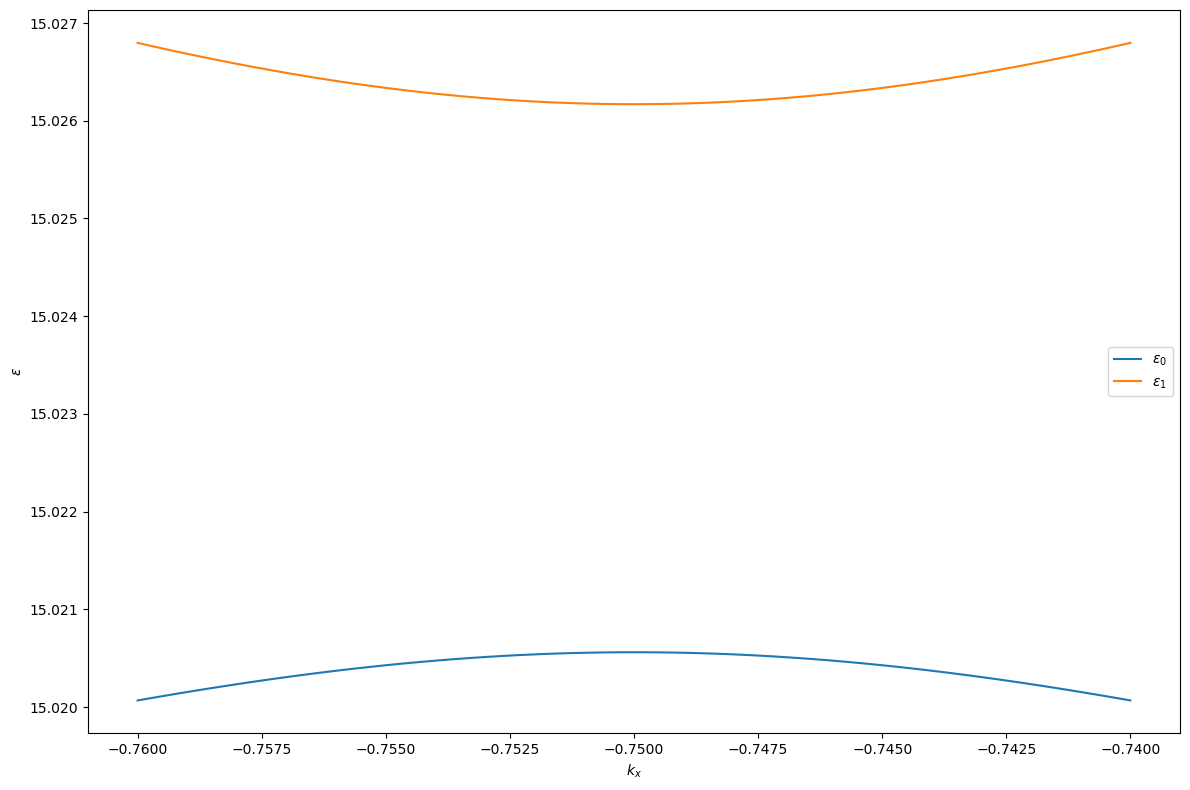

In [95]:
# set the relevant parameters
lambda = 1.1
# lambda = 0.5
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-3)
ky = sqrt(3)/4
llm = -3/4 - 0.01
ulm = -3/4 + 0.01
gap = 10

vF = 0.75

plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

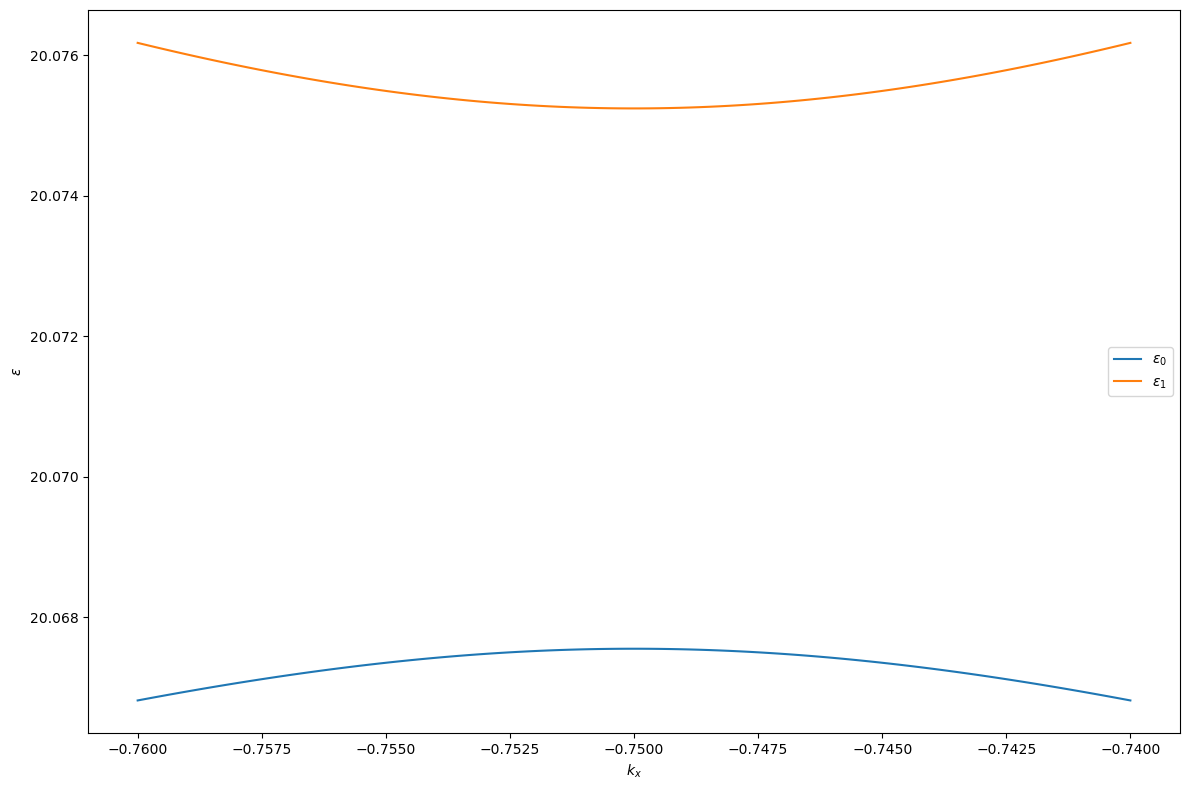

In [96]:
# set the relevant parameters
lambda = 1.1
# lambda = 0.5
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-3)
ky = sqrt(3)/4
llm = -3/4 - 0.01
ulm = -3/4 + 0.01
gap = 10

vF = 1

plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

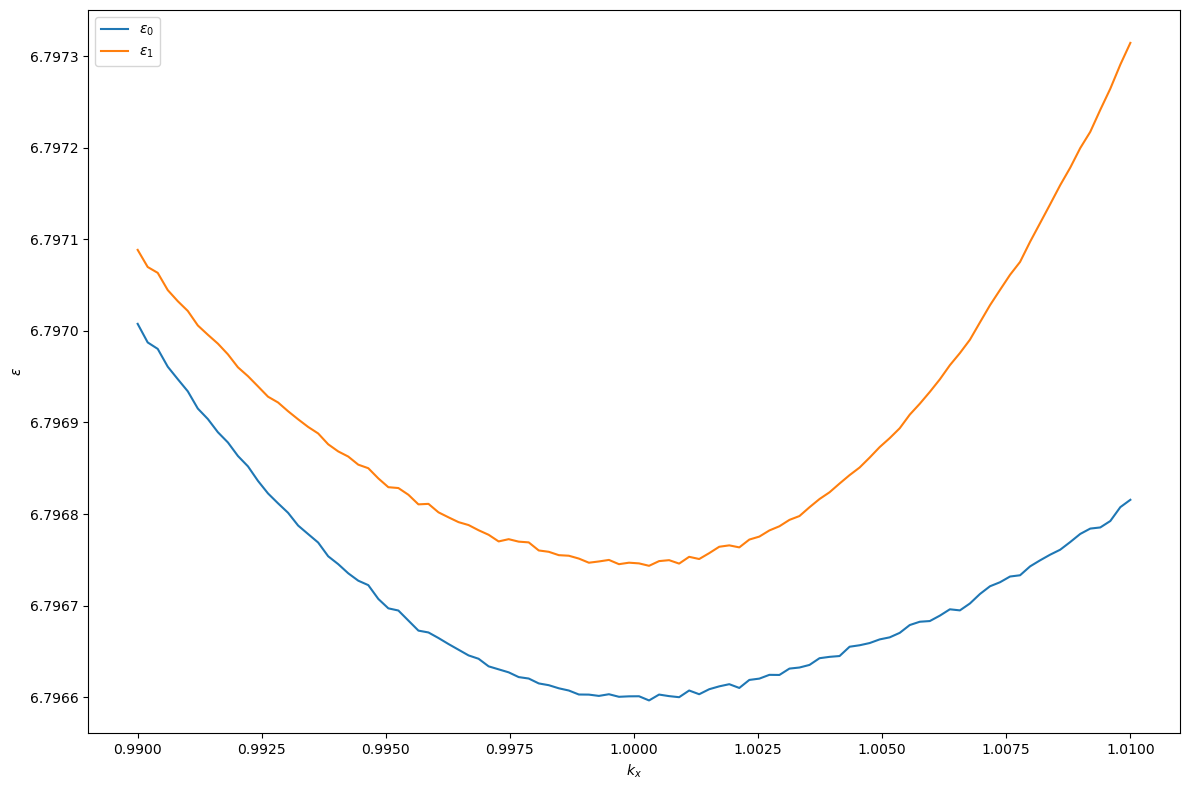

In [97]:
# set the relevant parameters
lambda = 0.9998924 + 0.0001
# lambda = 0.5
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
ky = 0
llm = 0.99
ulm = 1.01
gap = 10

vF = 0.7475 + 0.02

plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

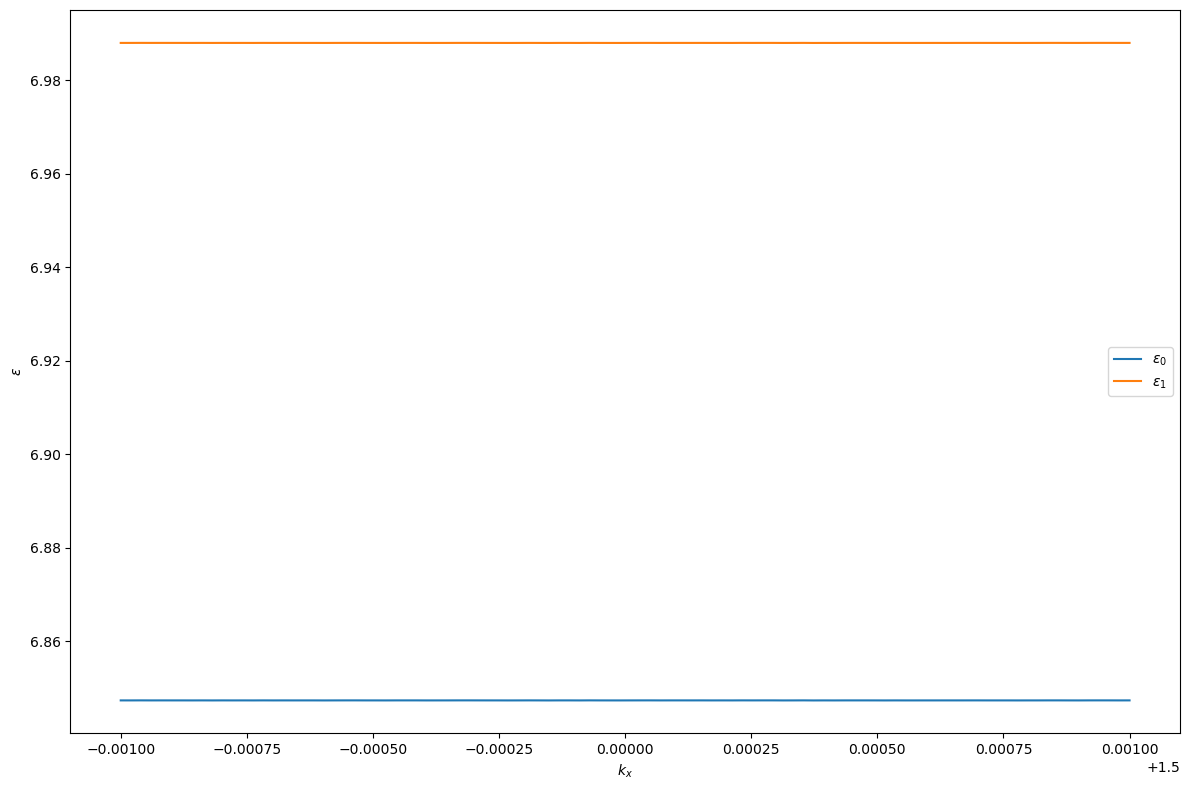

In [98]:
# set the relevant parameters
lambda = 0.9998924 + 0.0001
# lambda = 0.5
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
ky = 0
llm = 1.499
ulm = 1.501
gap = 10

vF = 0.7475 + 0.01

plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

## Symmetry indicator plots

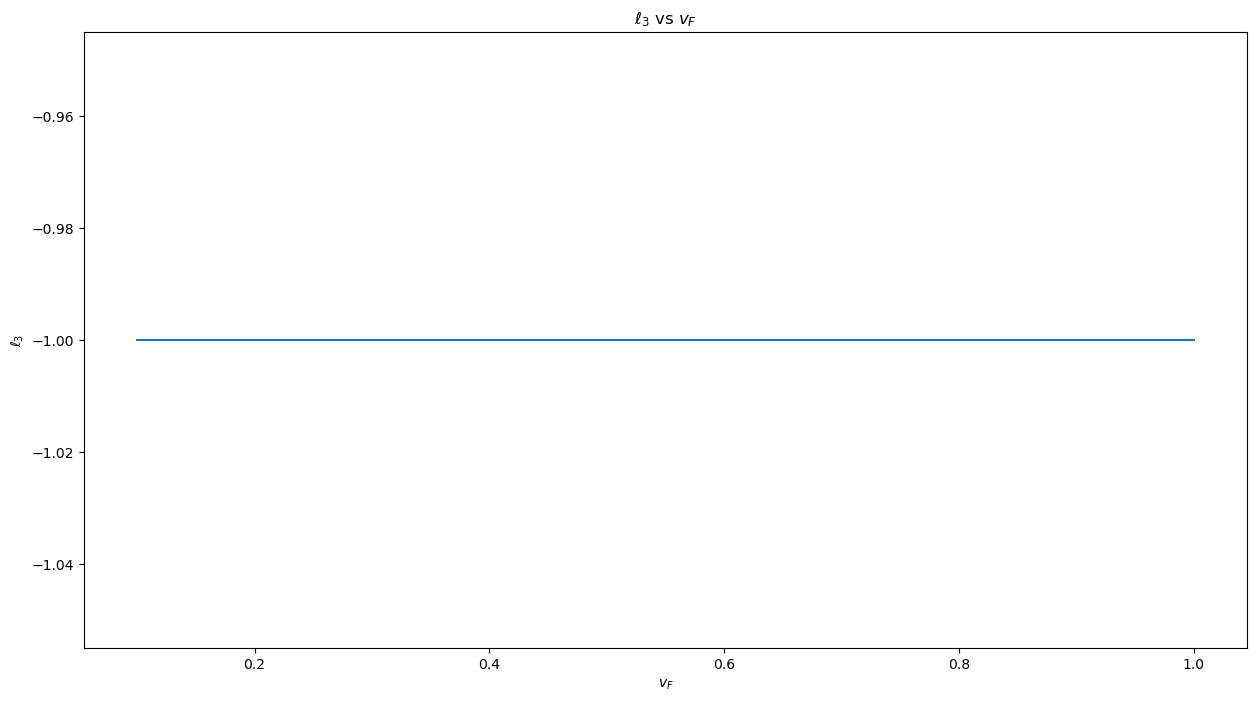

In [12]:
n = 10
gap = 10
lambda = 1.1
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.1
ulm = 1
plot_C3_phase_vF(n, gap, lambda, kappa, V, shells, llm, ulm)

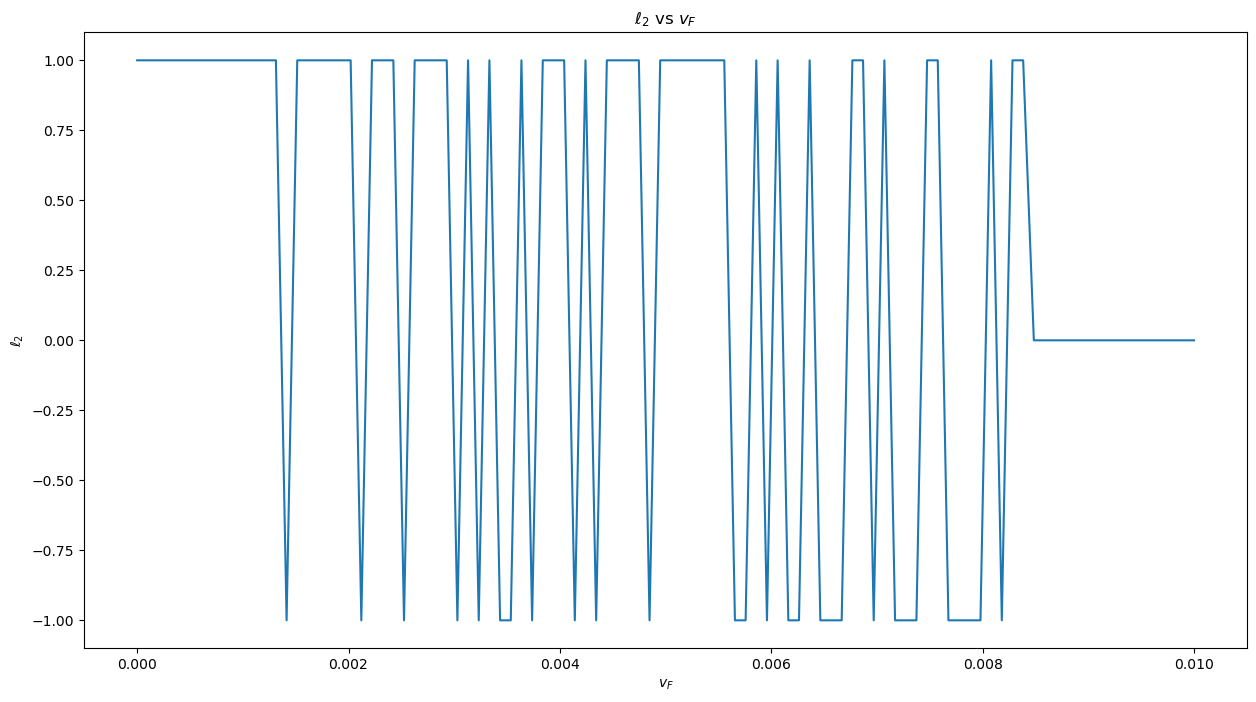

In [44]:
n = 22
gap = 10
lambda = 1
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0
ulm = 10^(-2)
plot_C2_phase_vF(n, gap, lambda, kappa, V, shells, llm, ulm)

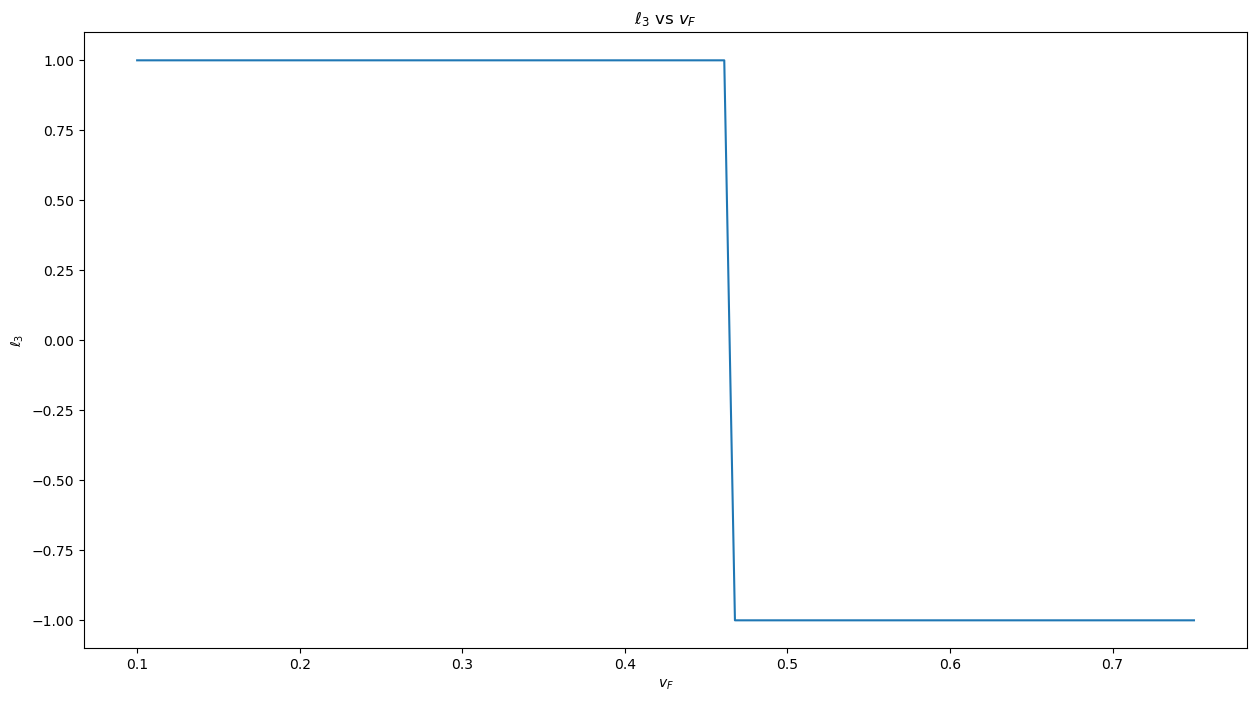

In [22]:
n = 4
gap = 10
lambda = 3
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.1
ulm = 0.75
plot_C3_phase_vF(n, gap, lambda, kappa, V, shells, llm, ulm)

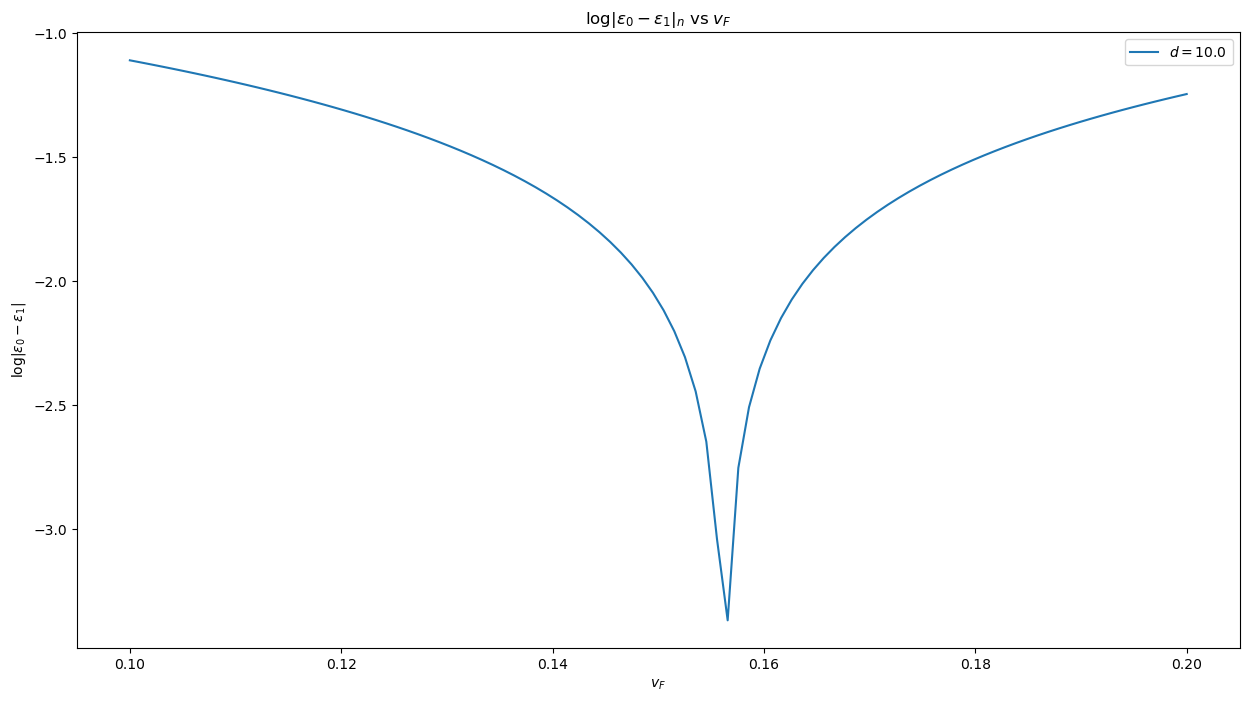

In [10]:
kappa = 1
q = kappa * [0, 0]
n = 4
gap_list = [10]
lambda = 1.1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.1
ulm = 0.2
plot_gap_vF_v3(q, n, gap_list, lambda, kappa, V, shells, llm, ulm)

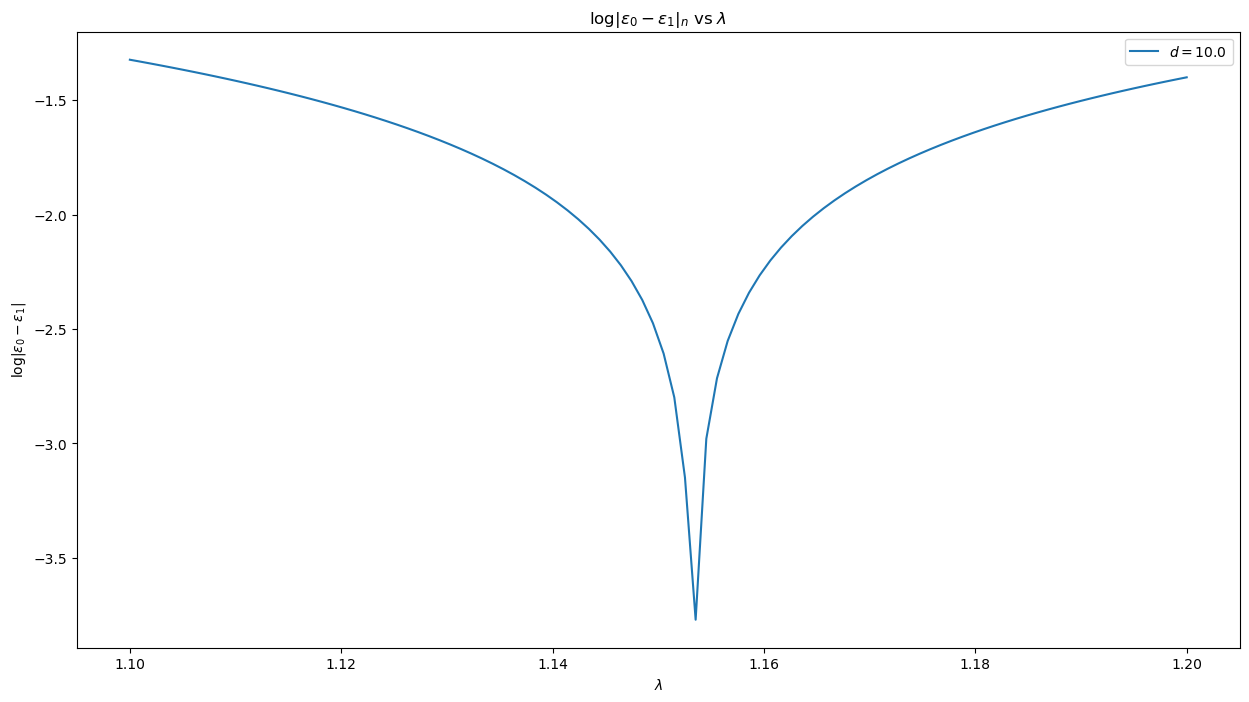

In [93]:
q = kappa * [-3/4, sqrt(3)/4]
n = 22
gap_list = [10]
vF = 3
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 1.1
ulm = 1.2
plot_gap_lambda_v3(q, n, gap_list, vF, kappa, V, shells, llm, ulm)

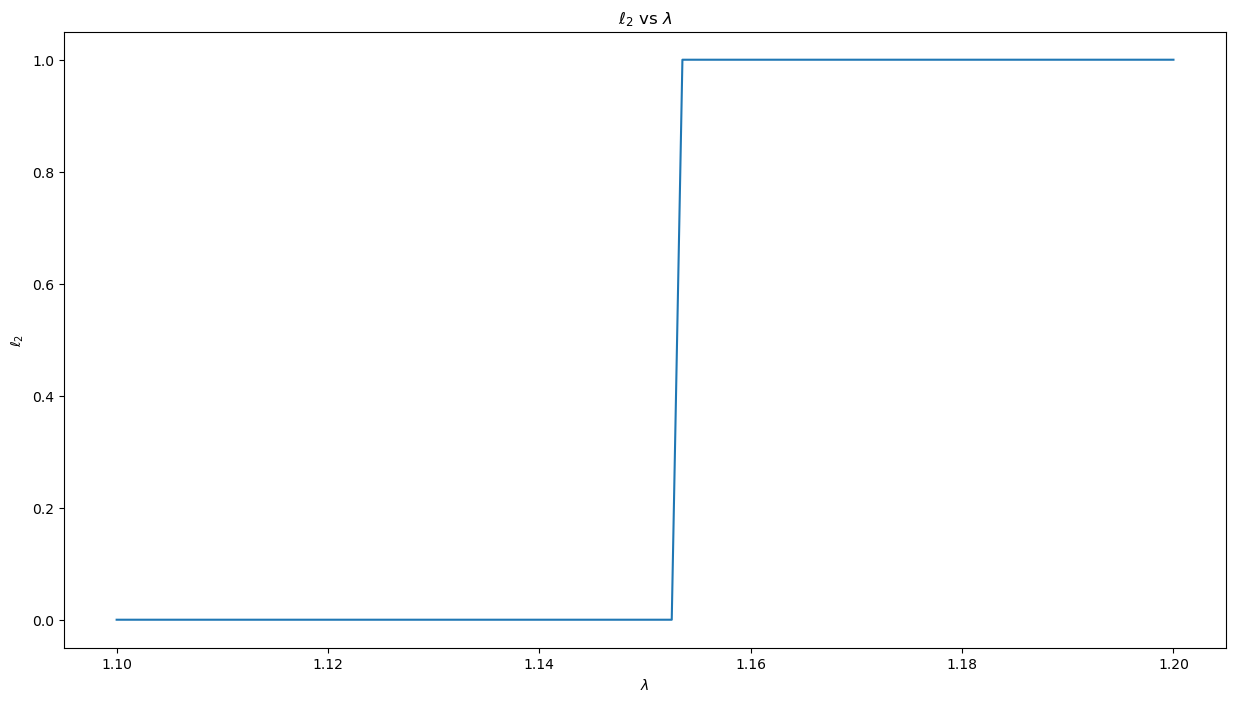

In [119]:
n = 22
gap = 10
vF = 3
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 1.1
ulm = 1.2
plot_C2_phase_lambda(n, gap, vF, kappa, V, shells, llm, ulm)

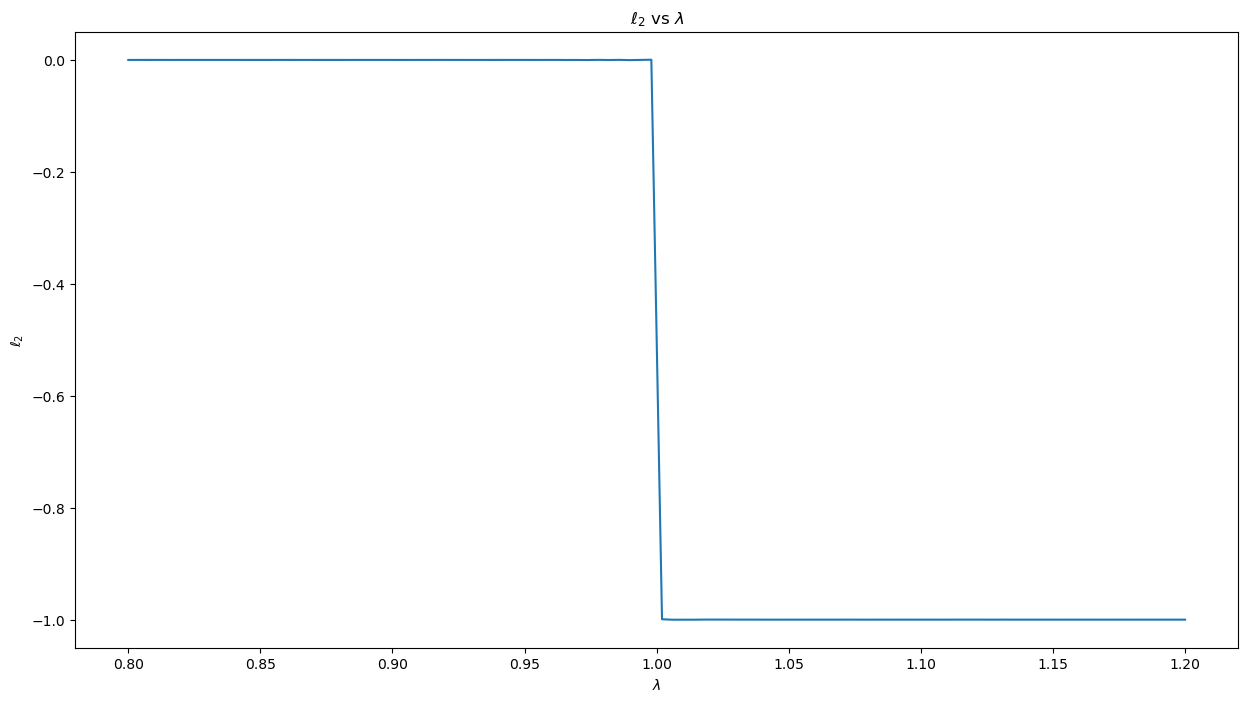

In [122]:
n = 22
gap = 10
vF = 3
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.8
ulm = 1.2
plot_C3_phase_lambda(n, gap, vF, kappa, V, shells, llm, ulm)

## Other Stuff

In [ ]:
# set the relevant parameters
lambda = 0.9998924
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-6)
gap = 10
vF = 0.7475
mag = 0.007

plot_energy_ang_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, mag)


In [ ]:
lambda = 0.9998924
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-3)
gap = 10
mag = 0.004
index = 1
llm = 0.74
ulm = 0.76

plot_vF_crit(lambda, n, gap, kappa, V, shells, bc_spacing, mag, index, llm, ulm)

In [ ]:
# set the relevant parameters
lambda = 0.9998924
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.99
ulm = 1.01
gap = 10
dmu = 10^(-3)
vF = 0.7457

plot_energy_slopes_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, dmu, llm, ulm)

In [ ]:
lambda = 0.9998924 + 0.00003
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.7475
index = 1

k_mag = 0.00625

plot_ang_bc_v3(gap, vF, n, lambda, kappa, V, shells, index, bc_spacing, k_mag)

## Paper plots

In [7]:
function plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, spacing, shift)
    n_pts = 10^2
    
    kx_list = range(kappa - shift, kappa + shift, n_pts)
    ky_list = shift * range(-1, 1, n_pts)
    grid = mesh_grid(kx_list, ky_list, Float64)

    # k_list = range(-kappa, kappa, n_pts)
    # grid = mesh_grid(k_list, k_list, Float64)


    bc_list = grid_bc_v3(grid, lambda, n, gap, vF, kappa, V, shells, index, spacing) / pi

    grid_new = reshape(grid, (n_pts, n_pts, 2))
    bc_list_new = reshape(bc_list, (n_pts, n_pts))

    bc_min = minimum(bc_list_new)
    bc_max = maximum(bc_list_new)
    bc_abs = maximum(abs.([bc_min, bc_max]))

    fig, axs = plt.subplots(1,1,figsize=(8, 9))
    axs.set_xlabel(L"q_x", fontsize=16)
    axs.set_ylabel(L"q_y", fontsize=16)
    xticks = [1]
    xlabels = [L"0"]
    axs.set_xticks(xticks, labels=xlabels)
    yticks = [0]
    ylabels = [L"0"]
    axs.set_yticks(yticks, labels=ylabels)

    #axs.yaxis.set_label_coords(-0.15, 0.47)
    # title(L"\Omega(k_x, k_y) \text{ vs } (k_x, k_y)")
    berry = pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], bc_list_new, cmap="RdBu")
    cbar = fig.colorbar(berry, orientation="horizontal", location="top")
    cbar.set_ticks([-30000, -15000, 0])
    cbar.set_ticklabels([L"-3 * 10^4 \pi", L"-1.5 * 10^4 \pi", "0"])
    fig
end

plot_bc_v3 (generic function with 1 method)

In [ ]:
# set the relevant parameters
lambda = 0.9998924 + 0.00003
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.7475
index = 1
shift = 0.008
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

In [ ]:
# set the relevant parameters
lambda = 0.9998924 + 0.00003
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.7475 - 0.003
index = 1
shift = 0.006
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

In [ ]:
# set the relevant parameters
lambda = 0.9998924 + 0.00003
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.7475 + 0.003
index = 1
shift = 0.006
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

# Critical ($2n = 10$) plots

In [ ]:
# set the relevant parameters
q = [0, 0]
n = 10
gap_list = [10]
vF = 0.7457
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.9957941634
ulm = 0.9957941635
plot_gap_lambda_v3(q, n, gap_list, vF, kappa, V, shells, llm, ulm)

In [ ]:
# set the relevant parameters
q = [0, 0]
n = 10
gap_list = [10]
lambda = 0.99579416342
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.745700
ulm = 0.745710
plot_gap_vF_v3(q, n, gap_list, lambda, kappa, V, shells, llm, ulm)

In [ ]:
# set the relevant parameters
lambda = 0.99579416342
# lambda = 0.5
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2)
ky = 0
llm = 0.99
ulm = 1.01
gap = 10

vF = 0.7457

plot_energy_line_v3(lambda, n, gap, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

In [11]:
function plot_bc_v3_n(lambda, n, vF, gap, kappa, V, shells, index, spacing, shift)
    n_pts = 10^2
    
    kx_list = range(kappa - shift, kappa + shift, n_pts)
    ky_list = shift * range(-1, 1, n_pts)
    grid = mesh_grid(kx_list, ky_list, Float64)

    # k_list = range(-kappa, kappa, n_pts)
    # grid = mesh_grid(k_list, k_list, Float64)


    bc_list = grid_bc_v3(grid, lambda, n, gap, vF, kappa, V, shells, index, spacing) / pi

    grid_new = reshape(grid, (n_pts, n_pts, 2))
    bc_list_new = reshape(bc_list, (n_pts, n_pts))

    bc_min = minimum(bc_list_new)
    bc_max = maximum(bc_list_new)
    bc_abs = maximum(abs.([bc_min, bc_max]))

    fig, axs = plt.subplots(1,1,figsize=(8, 9))
    axs.set_xlabel(L"q_x", fontsize=16)
    axs.set_ylabel(L"q_y", fontsize=16)
    xticks = [1]
    xlabels = [L"0"]
    # axs.set_xticks(xticks, labels=xlabels)
    yticks = [0]
    ylabels = [L"0"]
    # axs.set_yticks(yticks, labels=ylabels)

    #axs.yaxis.set_label_coords(-0.15, 0.47)
    # title(L"\Omega(k_x, k_y) \text{ vs } (k_x, k_y)")
    berry = pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], bc_list_new, cmap="RdBu")
    cbar = fig.colorbar(berry, orientation="horizontal", location="top")
    # cbar.set_ticks([-30000, -15000, 0])
    # cbar.set_ticklabels([L"-3 * 10^4 \pi", L"-1.5 * 10^4 \pi", "0"])
    fig
end

plot_bc_v3_n (generic function with 1 method)

In [ ]:
# set the relevant parameters
lambda = 0.99579416342 + 0.00003
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
gap = 10
vF = 0.7457
index = 1
shift = 0.008
plot_bc_v3_n(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

In [9]:
display(abs(lambda_alpha(0.9, 1, -1, -1)))

0.7472248880762029

# AHC/WC Phenomenology ($2n = 22$)

In [10]:
function plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, spacing, scale)
    n_pts = 10^2
    
    # kx_list = range(kappa - shift, kappa + shift, n_pts)
    # ky_list = shift * range(-1, 1, n_pts)
    # grid = mesh_grid(kx_list, ky_list, Float64)

    k_list = scale * range(-kappa, kappa, n_pts)
    grid = mesh_grid(k_list, k_list, Float64)


    bc_list = grid_bc_v3(grid, lambda, n, gap, vF, kappa, V, shells, index, spacing) / pi

    grid_new = reshape(grid, (n_pts, n_pts, 2))
    bc_list_new = reshape(bc_list, (n_pts, n_pts))

    bc_min = minimum(bc_list_new)
    bc_max = maximum(bc_list_new)
    bc_abs = maximum(abs.([bc_min, bc_max]))

    fig, axs = plt.subplots(1,1,figsize=(8, 9))
    axs.set_xlabel(L"q_x", fontsize=16)
    axs.set_ylabel(L"q_y", fontsize=16)
    xticks = [1]
    xlabels = [L"0"]
    # axs.set_xticks(xticks, labels=xlabels)
    yticks = [0]
    ylabels = [L"0"]
    # axs.set_yticks(yticks, labels=ylabels)

    #axs.yaxis.set_label_coords(-0.15, 0.47)
    # title(L"\Omega(k_x, k_y) \text{ vs } (k_x, k_y)")
    berry = pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], bc_list_new, cmap="RdBu", vmin = -bc_abs, vmax = bc_abs)
    cbar = fig.colorbar(berry, orientation="horizontal", location="top")
    # cbar.set_ticks([-30000, -15000, 0])
    # cbar.set_ticklabels([L"-3 * 10^4 \pi", L"-1.5 * 10^4 \pi", "0"])
    fig
end

plotter_bc_v3 (generic function with 1 method)

In [ ]:
# set the relevant parameters
lambda = 5
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.7475
index = 1
scale = 2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

In [ ]:
# set the relevant parameters
lambda = 0.9998924 + 0.0001
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.7475 + 0.2
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

In [ ]:
# set the relevant parameters
lambda = 0.9998924 + 0.0001
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.7475 + 0.2
index = 1
shift = 0.05
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

# More phenomenology

In [ ]:
# set the relevant parameters
lambda = 0.8
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.1
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

In [ ]:
# set the relevant parameters
lambda = 0.8
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

In [ ]:
# set the relevant parameters
lambda = 0.8
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 1
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

In [ ]:
# set the relevant parameters
lambda = 0.8
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 3
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

In [ ]:
# set the relevant parameters
lambda = 0.8
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

In [ ]:
# set the relevant parameters
lambda = 0.5
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

In [ ]:
# set the relevant parameters
lambda = 1.3
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 3
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

In [ ]:
# set the relevant parameters
lambda = 1.3
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 3
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

In [ ]:
# set the relevant parameters
lambda = 1.3
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.2
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

In [ ]:
# set the relevant parameters
lambda = 1.3
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.4
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

In [ ]:
# set the relevant parameters
lambda = 1.3
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 4
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

In [ ]:
# set the relevant parameters
lambda = 1.3
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

In [ ]:
# set the relevant parameters
lambda = 1.3
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 5
index = 1
shift = 0.6
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

In [ ]:
# set the relevant parameters
lambda = 0.9998924 + 0.00003
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.7475 + 0.5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

In [ ]:
# set the relevant parameters
lambda = 0.9998924 + 0.00003
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.7475 + 0.5
index = 1
shift = 0.09
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

## Miscellaneous considerations

In [ ]:
# set the relevant parameters
lambda = 0.9998924 + 0.00003
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-6)
gap = 10
vF = 0.7475
index = 1

temp = grid_phase_v3(reshape([1.004, 0], (1, 2)), lambda, n, gap, vF, kappa, V, shells, index, bc_spacing) / pi

In [ ]:
# set the relevant parameters
lambda = 0.9998924 + 0.00003 + 0.0003
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.7475
index = 1
shift = 0.006
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

In [ ]:
# set the relevant parameters
lambda = 0.9998924 + 0.00003 + 0.0003
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.7475
index = 1
shift = 0.03
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

In [ ]:
# set the relevant parameters
lambda = 0.9998924 + 0.00003 + 0.8
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.7475
index = 1
shift = 0.006
plot_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, shift)

# $2n = 10$ Catalog

## $C = 0$

### $\lambda = 0.1$

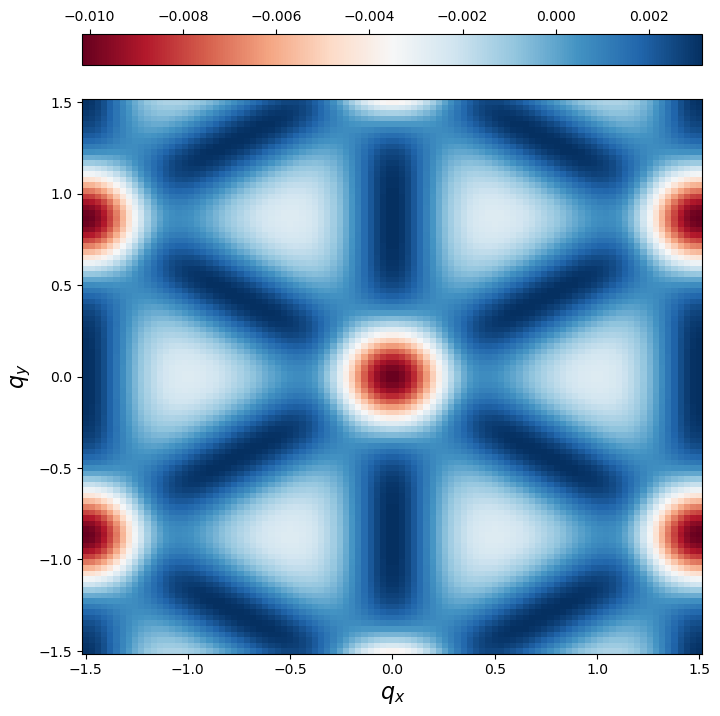

In [10]:
# set the relevant parameters
lambda = 0.1
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.1
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

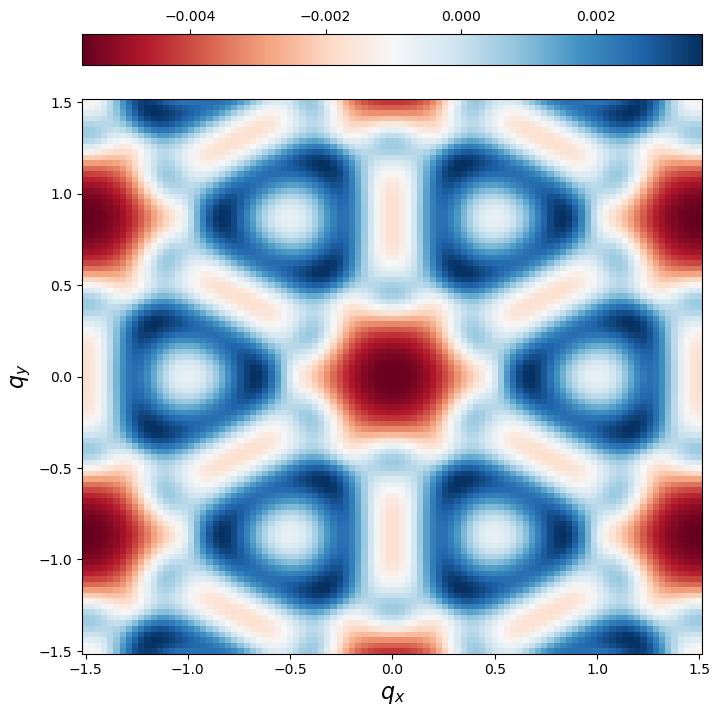

In [11]:
# set the relevant parameters
lambda = 0.1
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.75
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

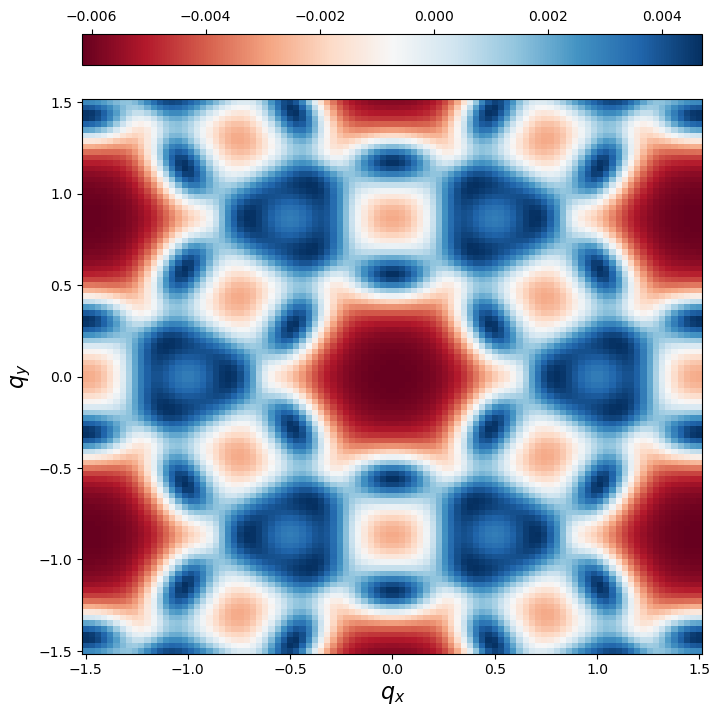

In [12]:
# set the relevant parameters
lambda = 0.1
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 1.5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

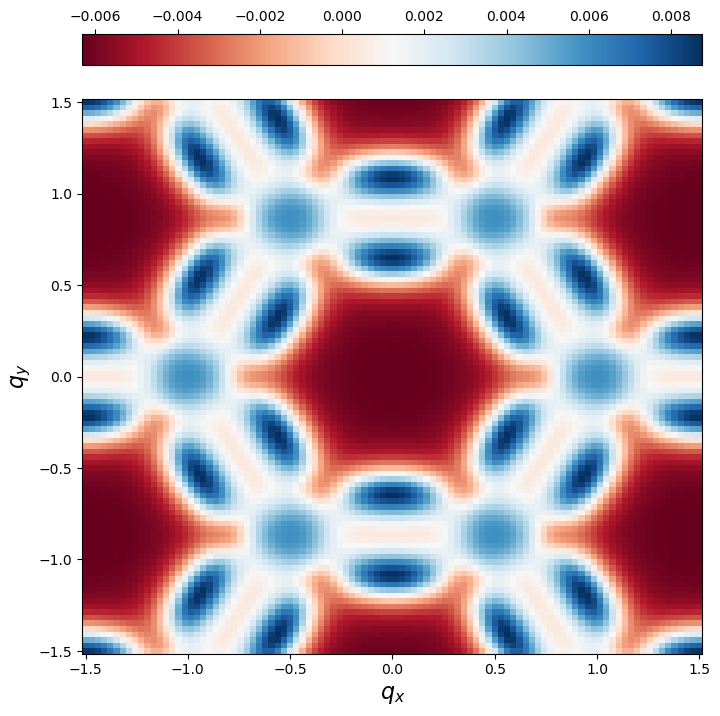

In [13]:
# set the relevant parameters
lambda = 0.1
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 3
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

### $\lambda = 0.5$

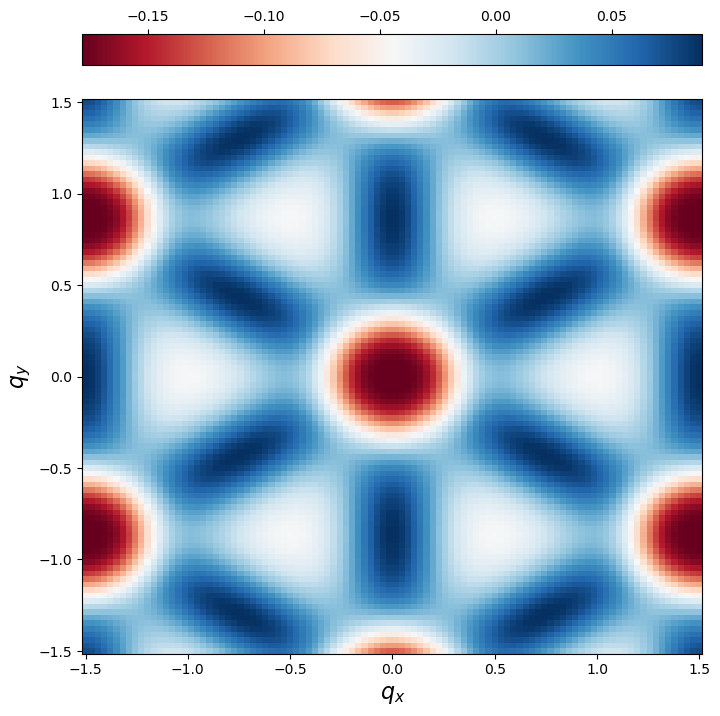

In [14]:
# set the relevant parameters
lambda = 0.5
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.1
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

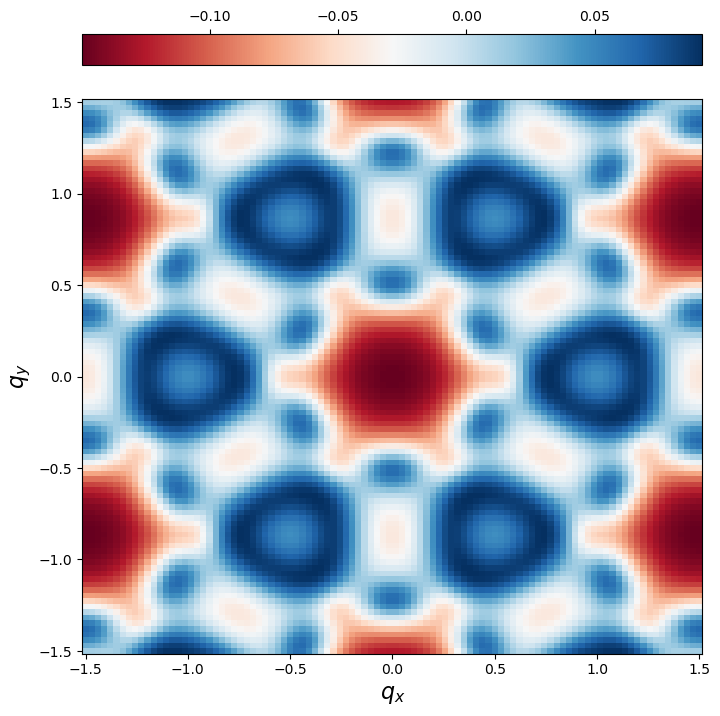

In [15]:
# set the relevant parameters
lambda = 0.5
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.75
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

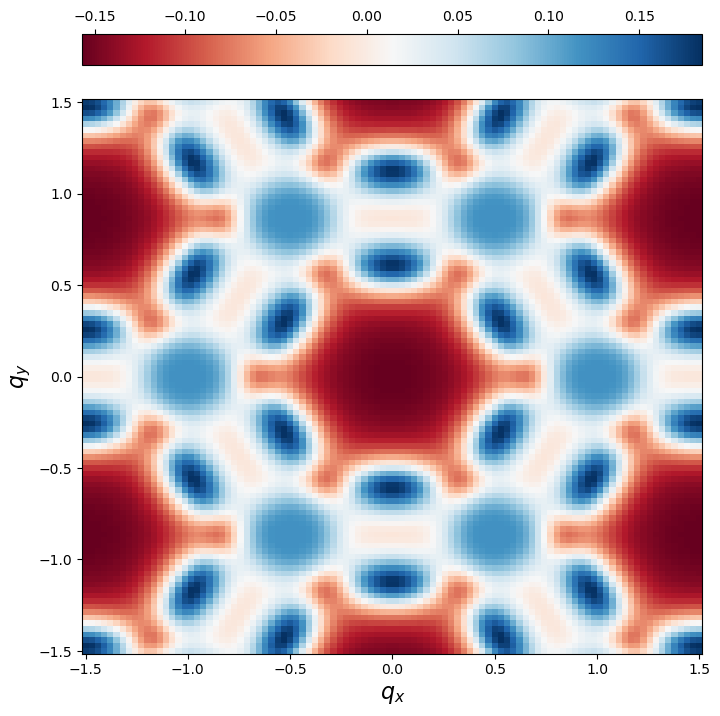

In [16]:
# set the relevant parameters
lambda = 0.5
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 1.5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

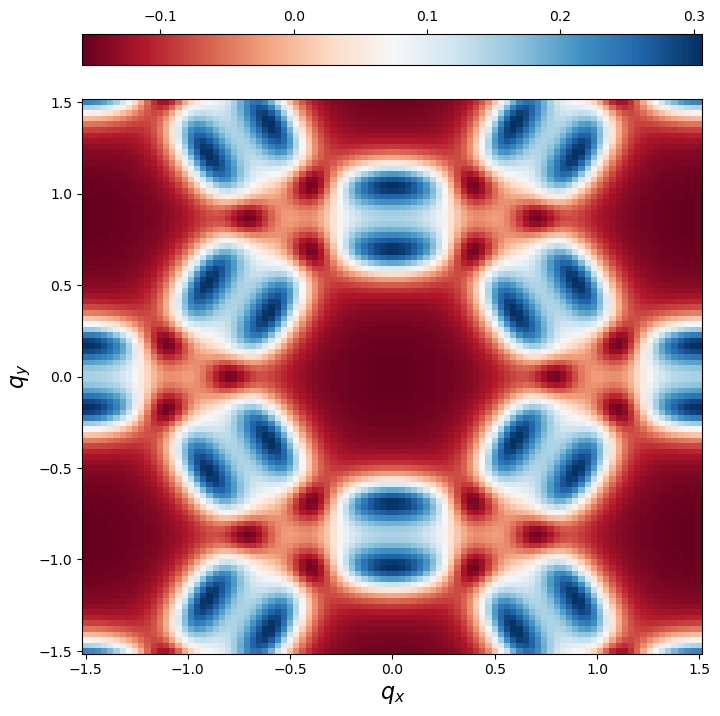

In [17]:
# set the relevant parameters
lambda = 0.5
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 3
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

### $\lambda = 0.8$

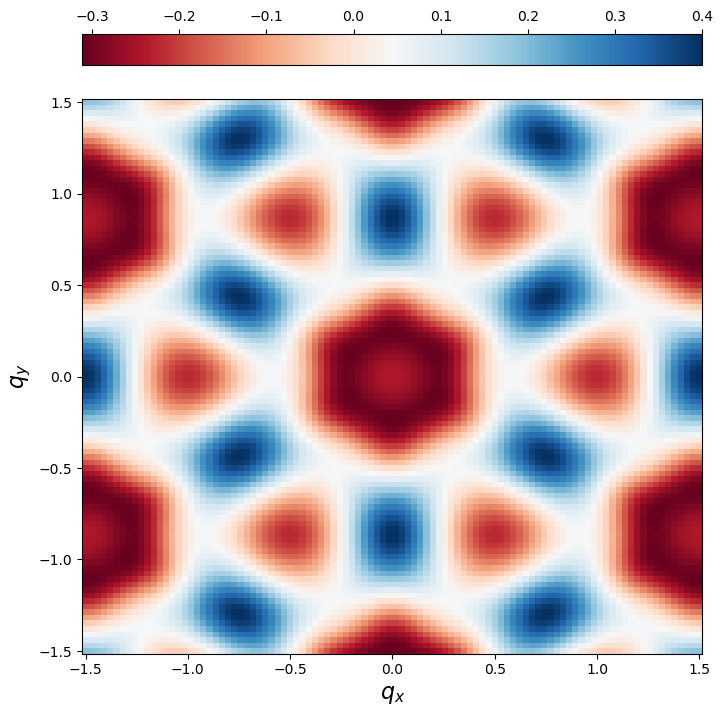

In [6]:
# set the relevant parameters
lambda = 0.8
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.1
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

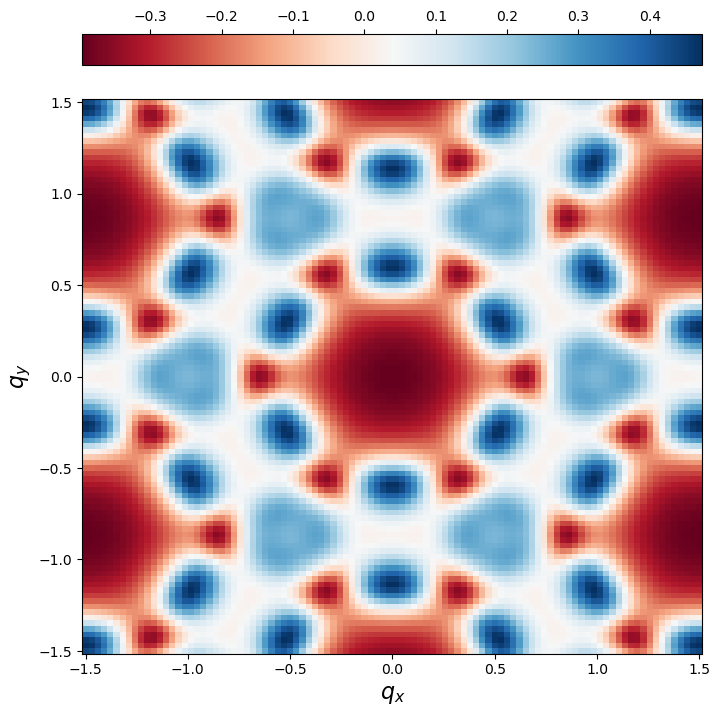

In [7]:
# set the relevant parameters
lambda = 0.8
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.75
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

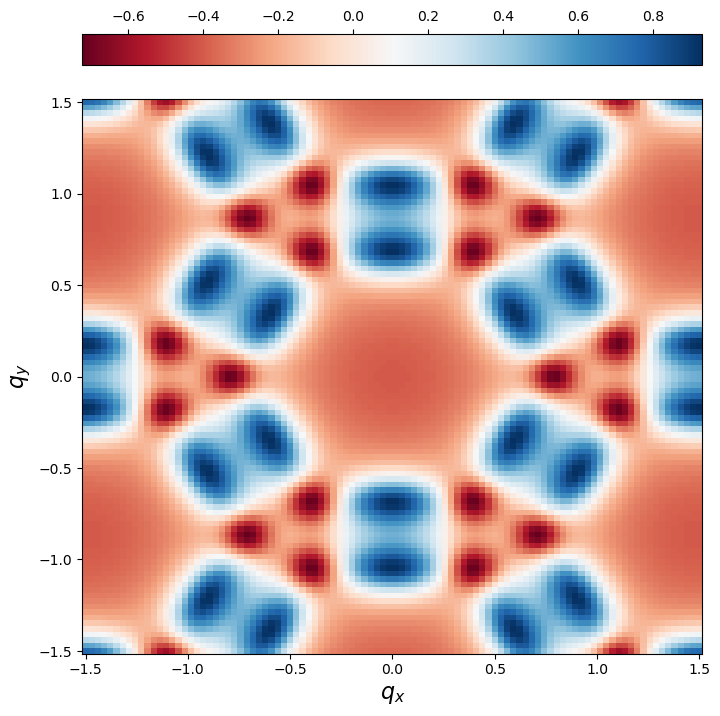

In [8]:
# set the relevant parameters
lambda = 0.8
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 1.5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

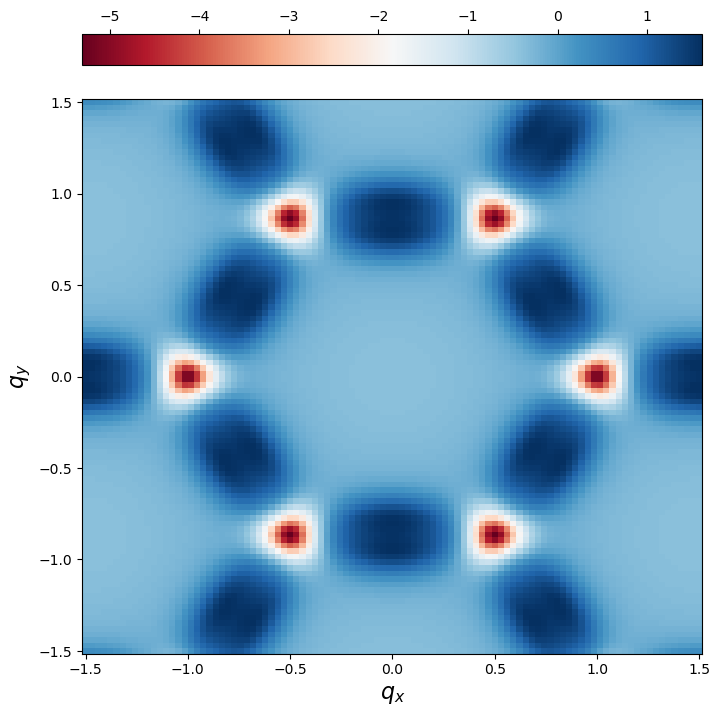

In [9]:
# set the relevant parameters
lambda = 0.8
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 3
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

## $C = -1$

### $\lambda = 1.1$

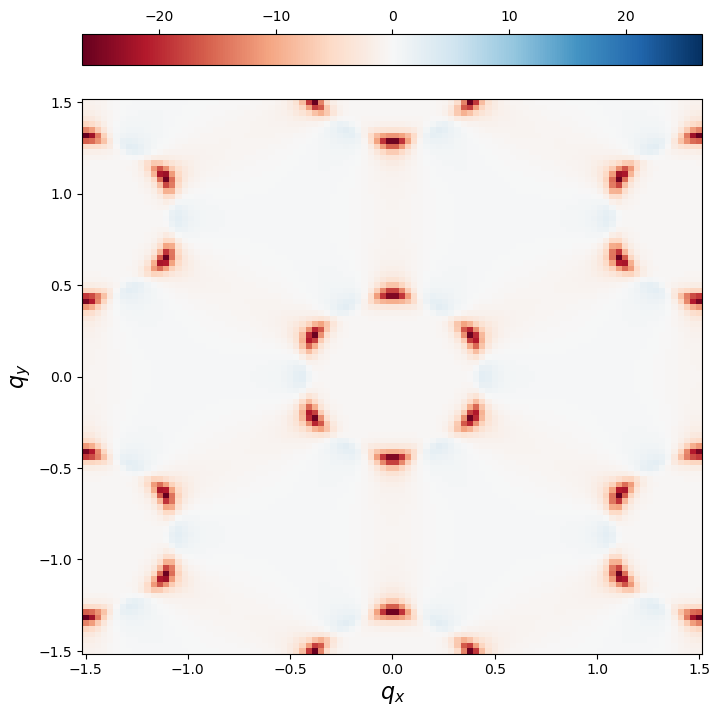

In [12]:
# set the relevant parameters
lambda = 1.1
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.1
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

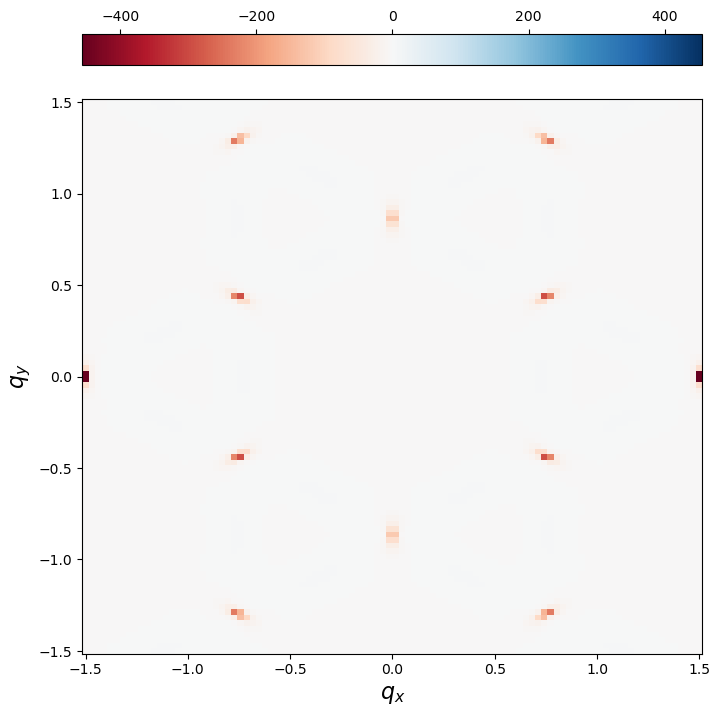

In [13]:
# set the relevant parameters
lambda = 1.1
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.75
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

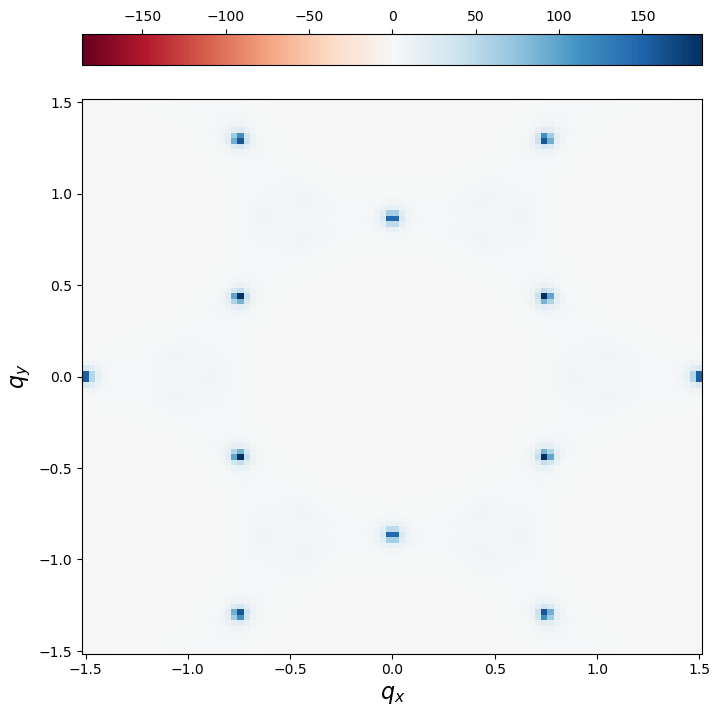

In [14]:
# set the relevant parameters
lambda = 1.1
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 1.5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

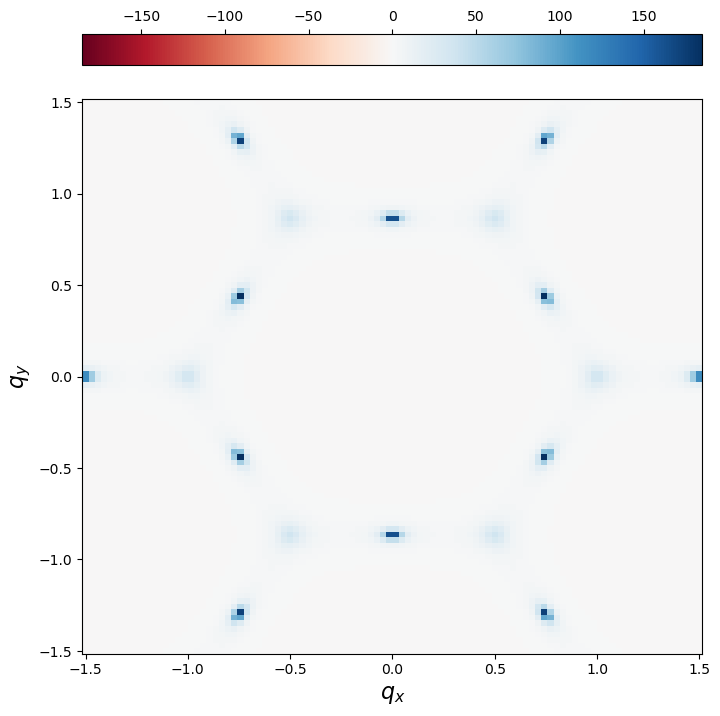

In [15]:
# set the relevant parameters
lambda = 1.1
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 3
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

### $\lambda = 1.5$

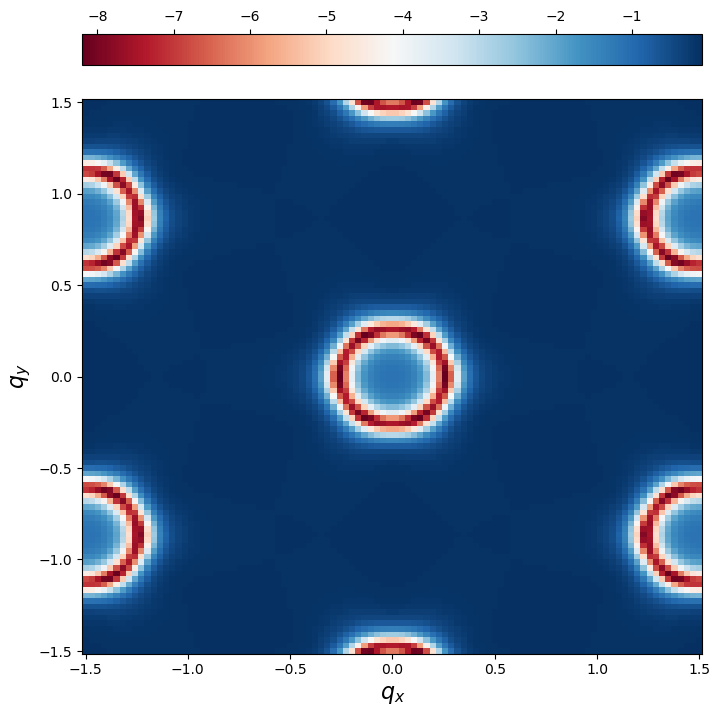

In [22]:
# set the relevant parameters
lambda = 1.5
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.1
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

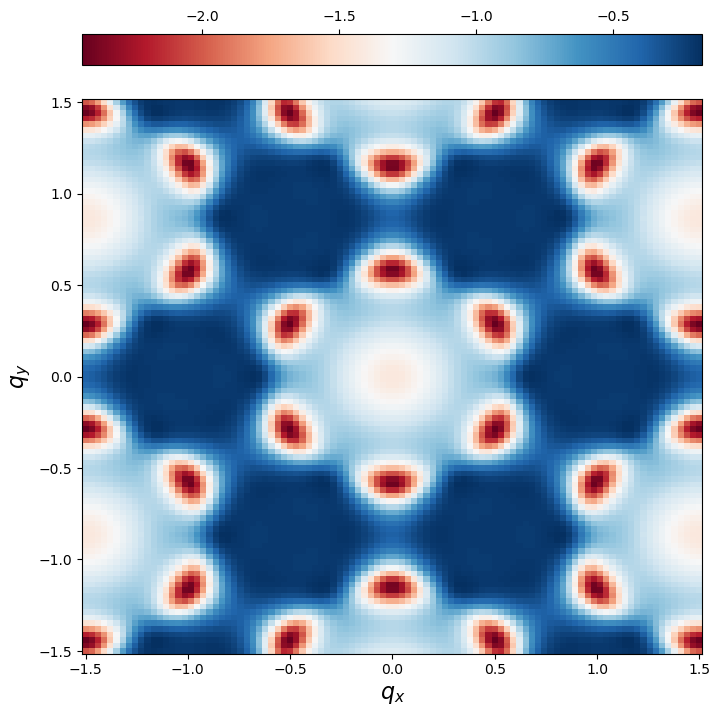

In [23]:
# set the relevant parameters
lambda = 1.5
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.75
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

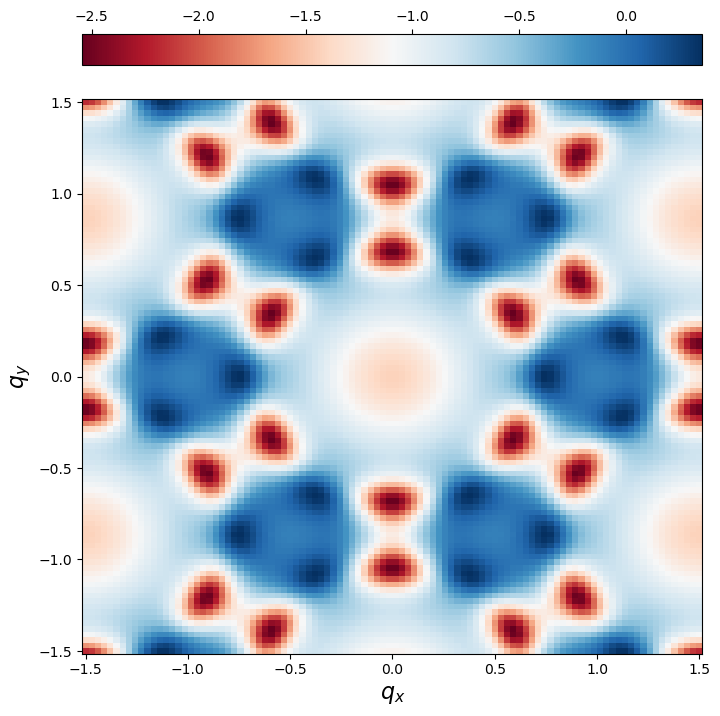

In [24]:
# set the relevant parameters
lambda = 1.5
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 1.5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

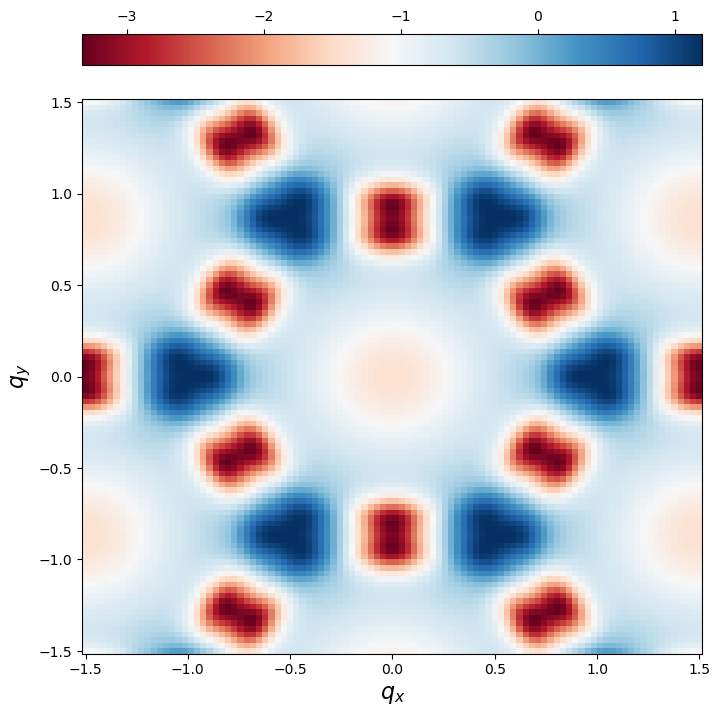

In [25]:
# set the relevant parameters
lambda = 1.5
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 3
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

### $\lambda = 3$

sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


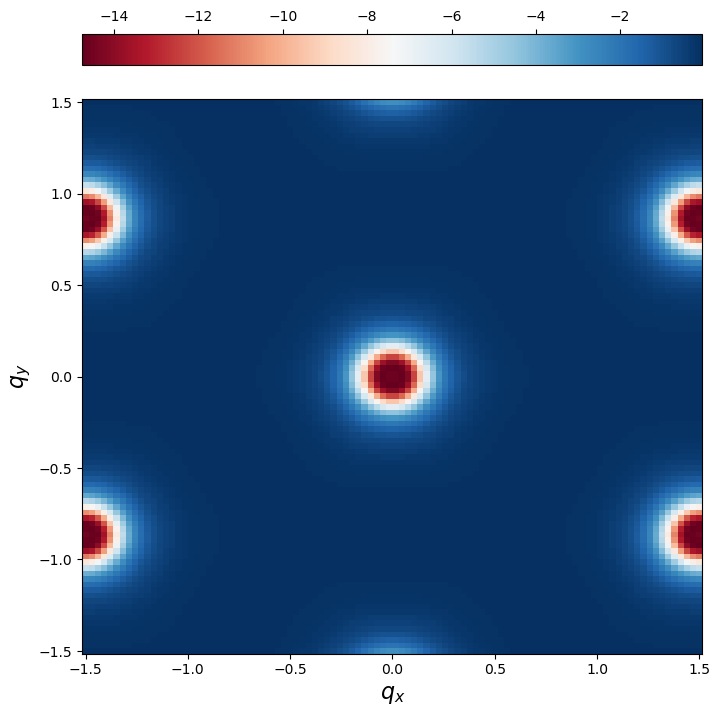

In [26]:
# set the relevant parameters
lambda = 3
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.1
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

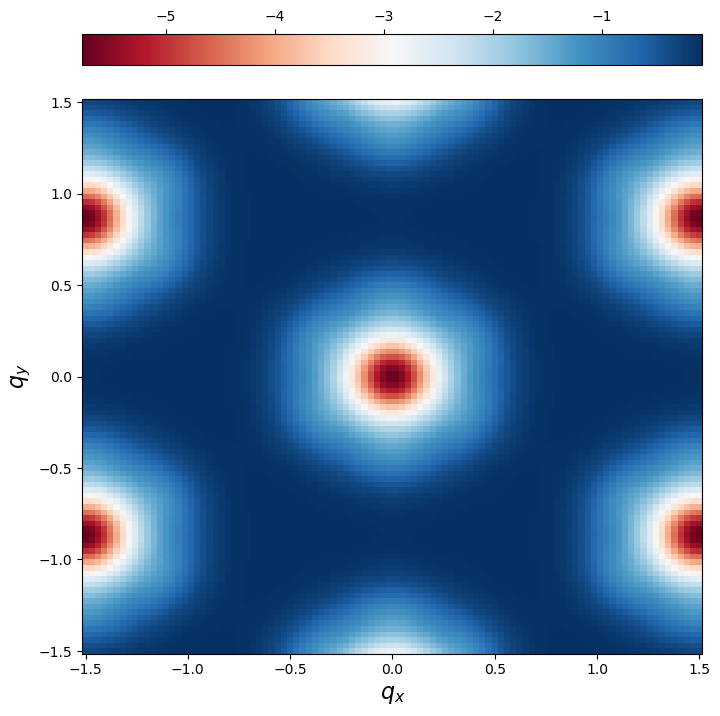

In [27]:
# set the relevant parameters
lambda = 3
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.75
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

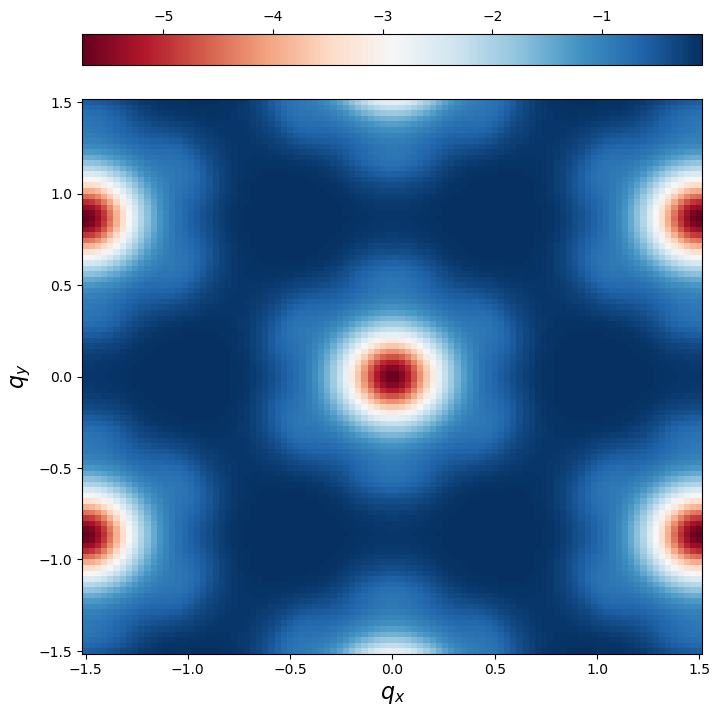

In [28]:
# set the relevant parameters
lambda = 3
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 1.5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

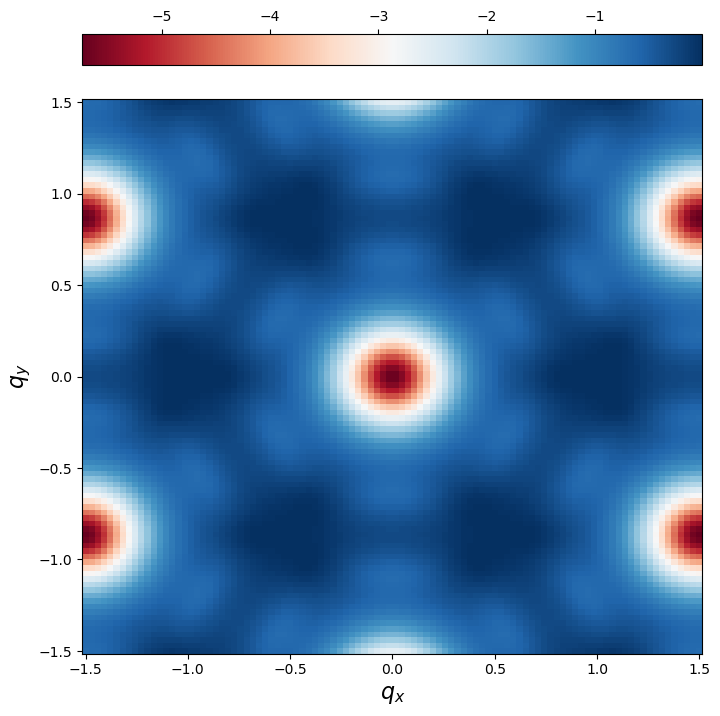

In [29]:
# set the relevant parameters
lambda = 3
n = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 3
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

# $2n = 22$ Catalog

## $C = 0$

### $\lambda = 0.1$

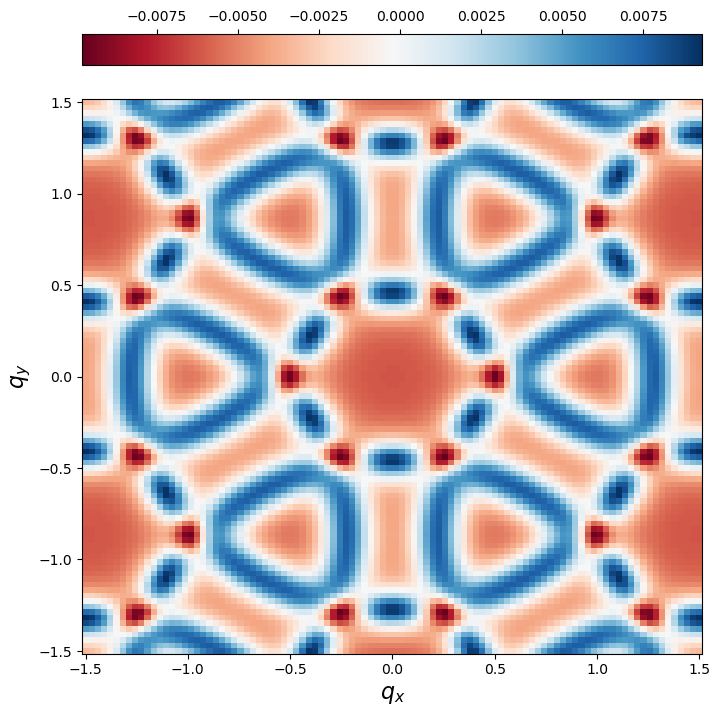

In [30]:
# set the relevant parameters
lambda = 0.1
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.1
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

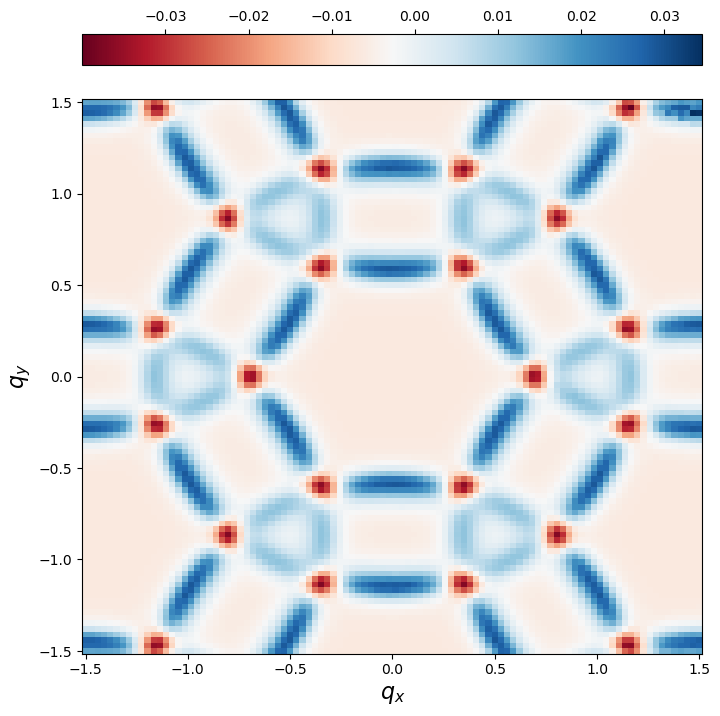

In [31]:
# set the relevant parameters
lambda = 0.1
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.75
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

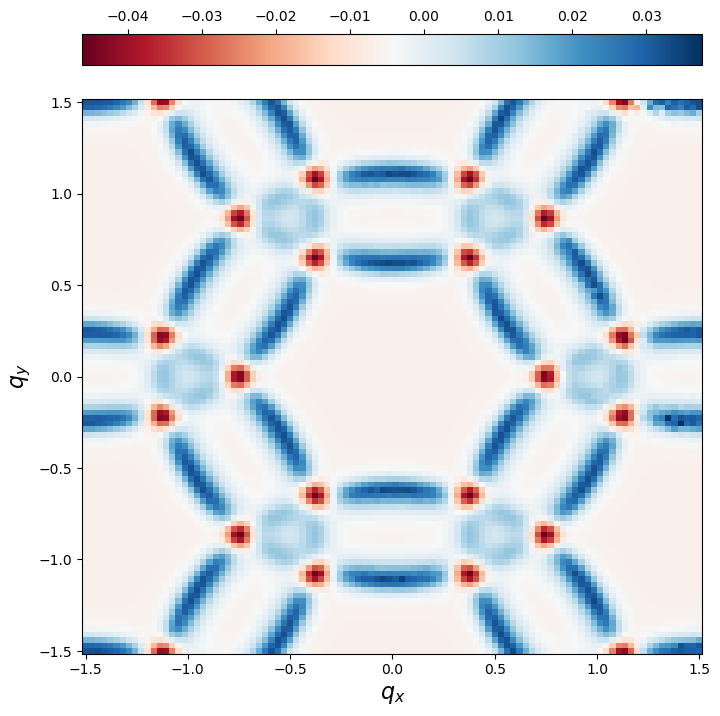

In [32]:
# set the relevant parameters
lambda = 0.1
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 1.5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

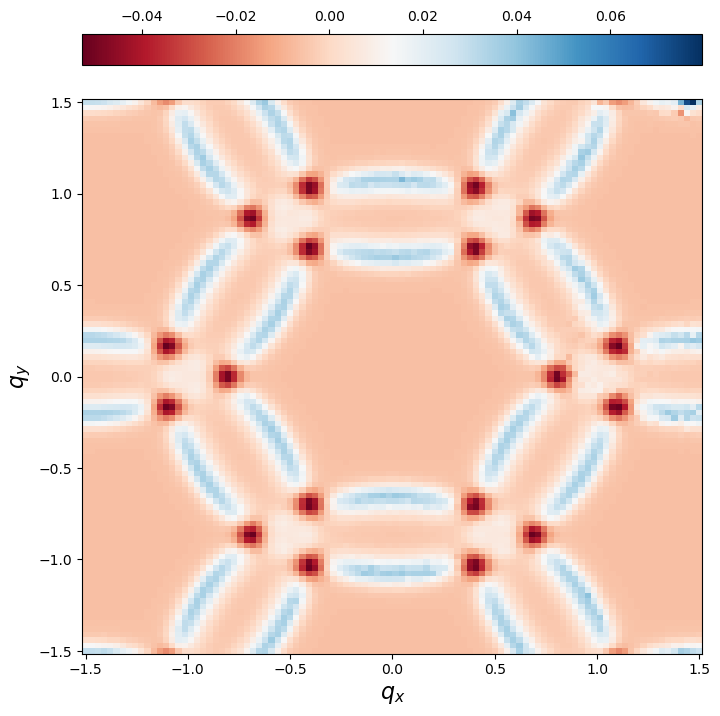

In [33]:
# set the relevant parameters
lambda = 0.1
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 3
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

### $\lambda = 0.5$

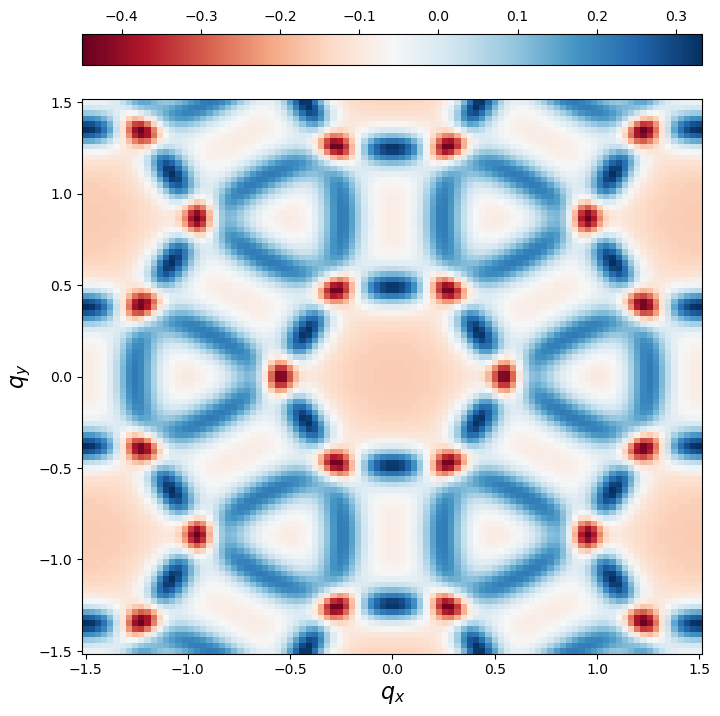

In [34]:
# set the relevant parameters
lambda = 0.5
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.1
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

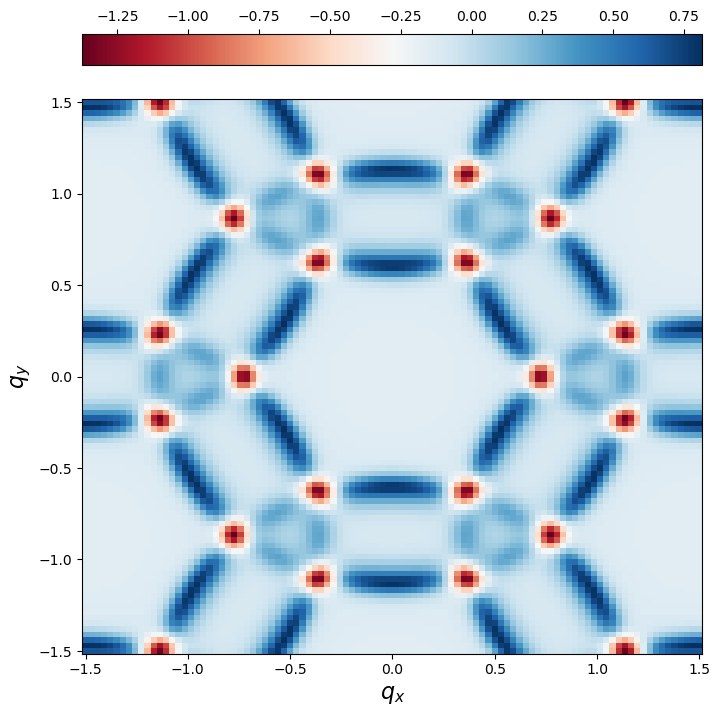

In [35]:
# set the relevant parameters
lambda = 0.5
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.75
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

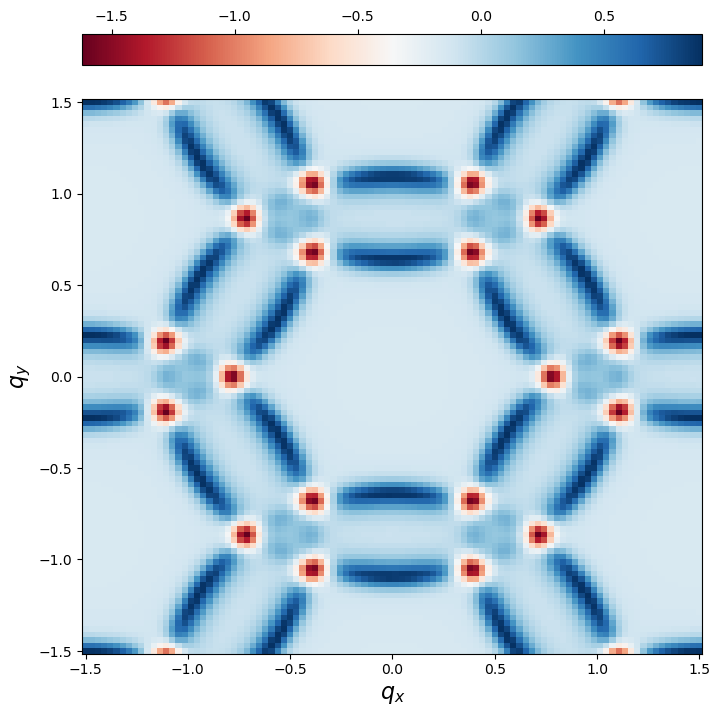

In [36]:
# set the relevant parameters
lambda = 0.5
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 1.5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

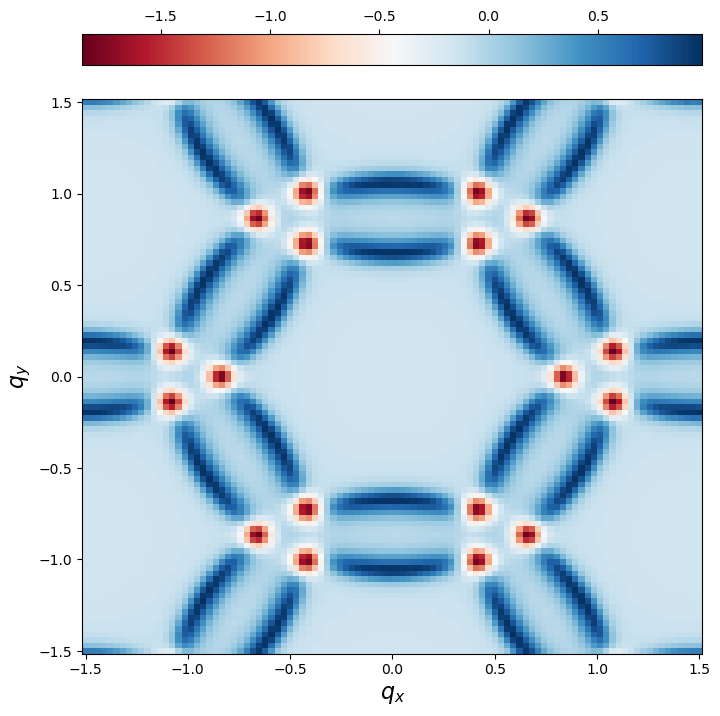

In [37]:
# set the relevant parameters
lambda = 0.5
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 3
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

### $\lambda = 0.8$

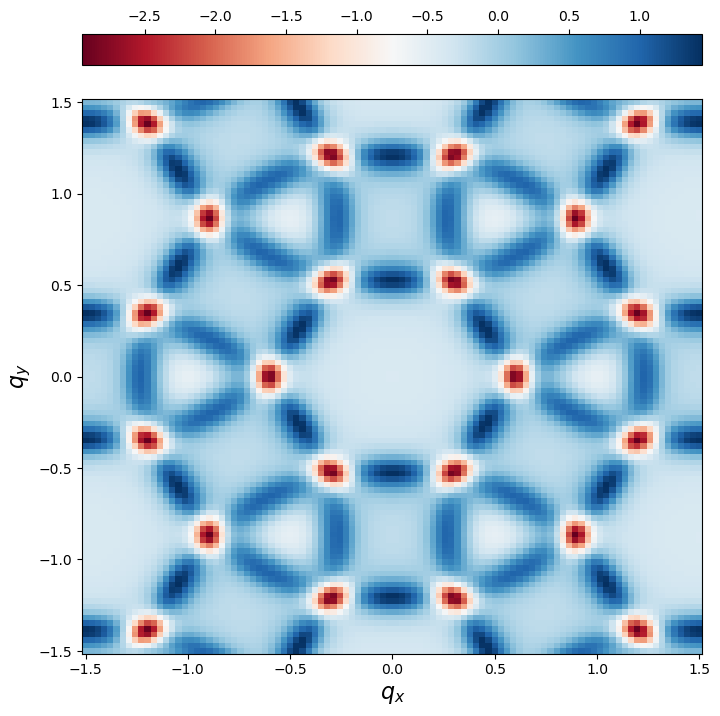

In [38]:
# set the relevant parameters
lambda = 0.8
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.1
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

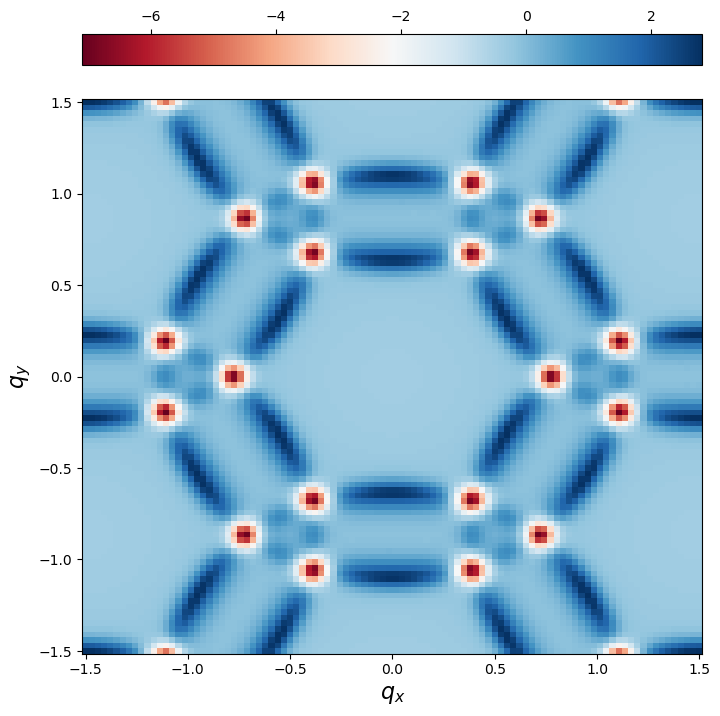

In [39]:
# set the relevant parameters
lambda = 0.8
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.75
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

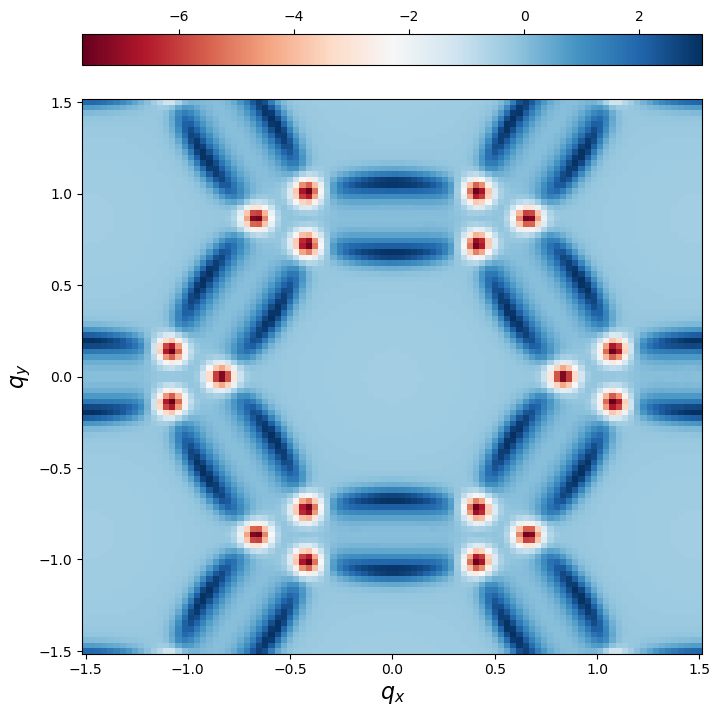

In [40]:
# set the relevant parameters
lambda = 0.8
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 1.5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

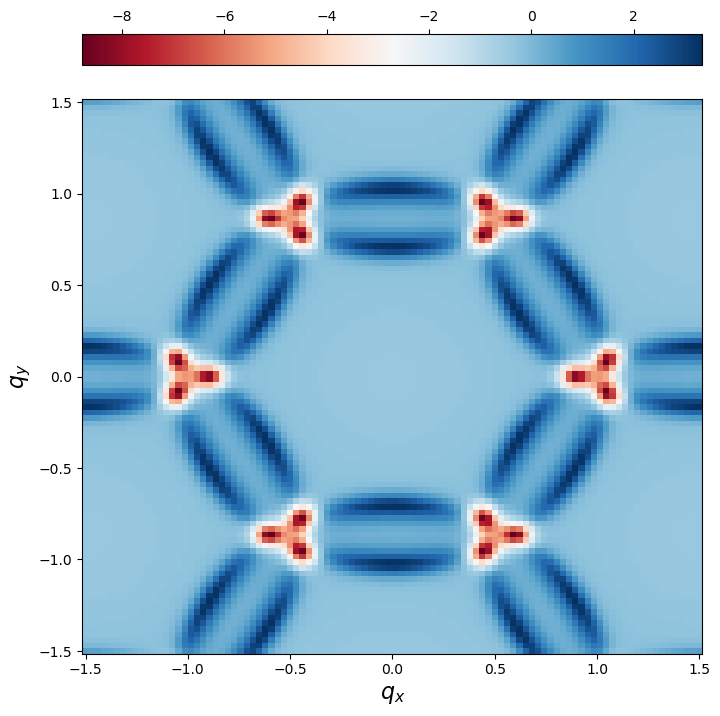

In [41]:
# set the relevant parameters
lambda = 0.8
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 3
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

## $C = -1$

### $\lambda = 1.1$

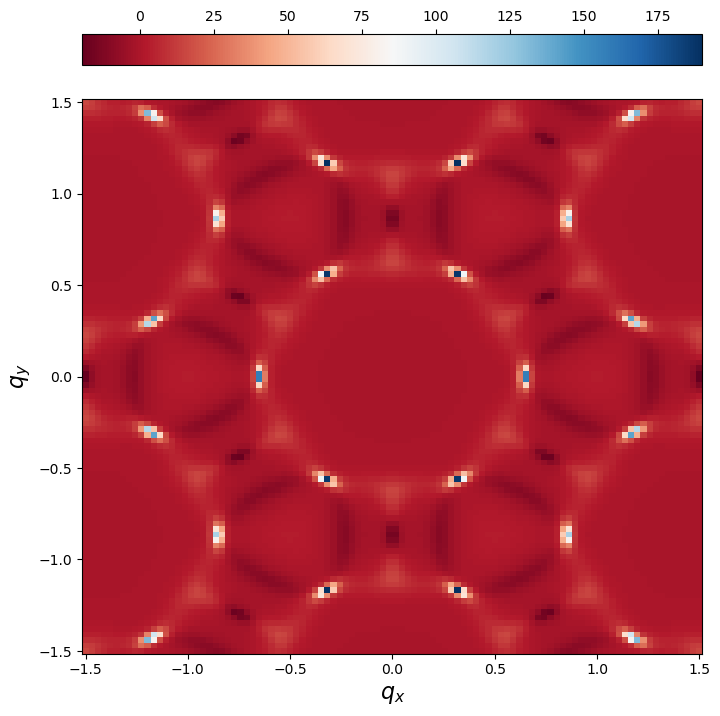

In [43]:
# set the relevant parameters
lambda = 1.1
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.1
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

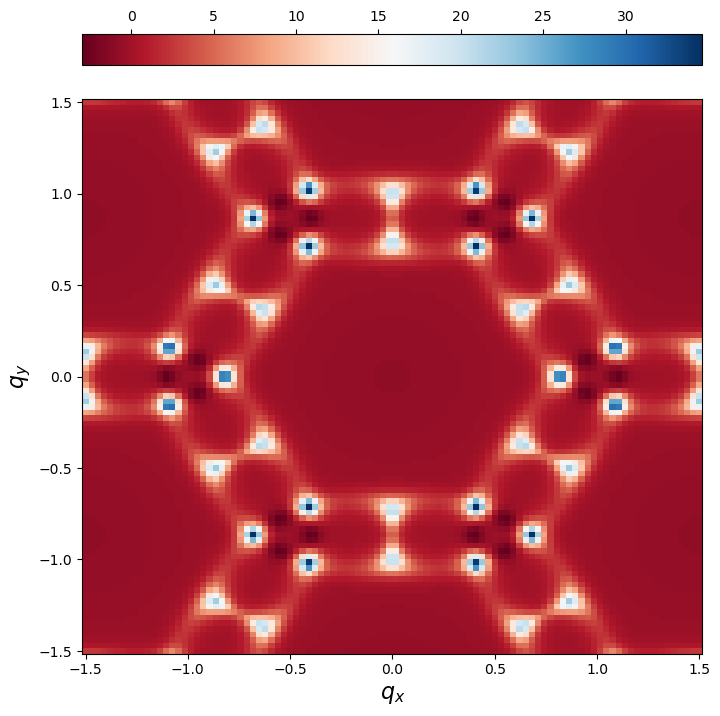

In [44]:
# set the relevant parameters
lambda = 1.1
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.75
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

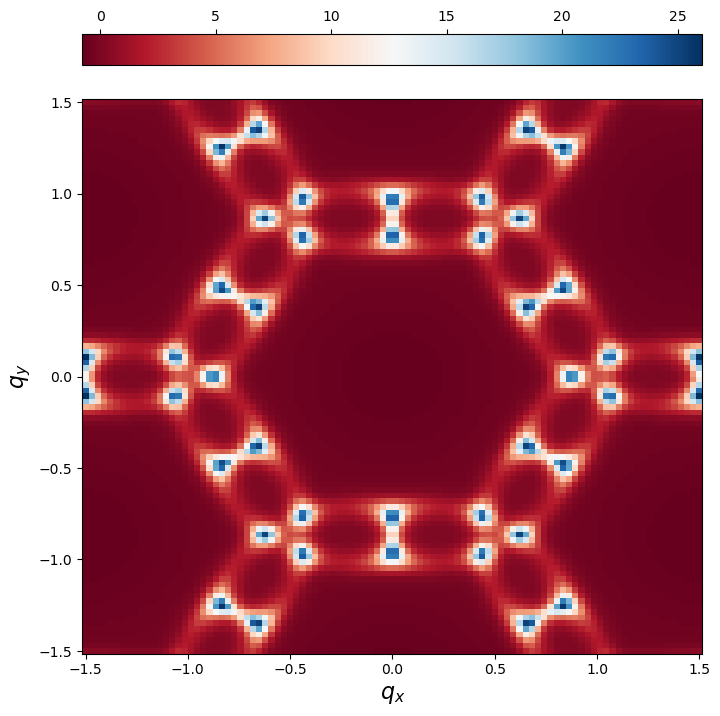

In [45]:
# set the relevant parameters
lambda = 1.1
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 1.5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

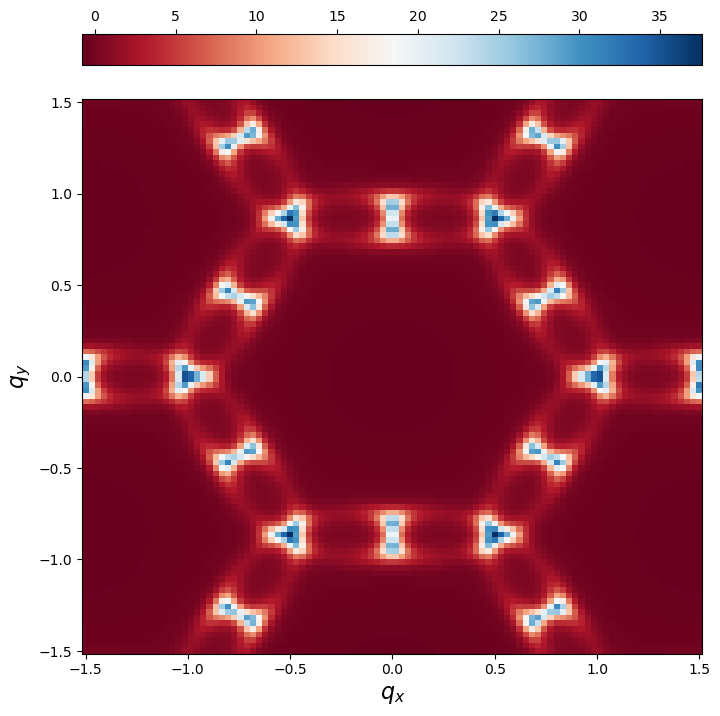

In [46]:
# set the relevant parameters
lambda = 1.1
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 3
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

### $\lambda = 1.5$

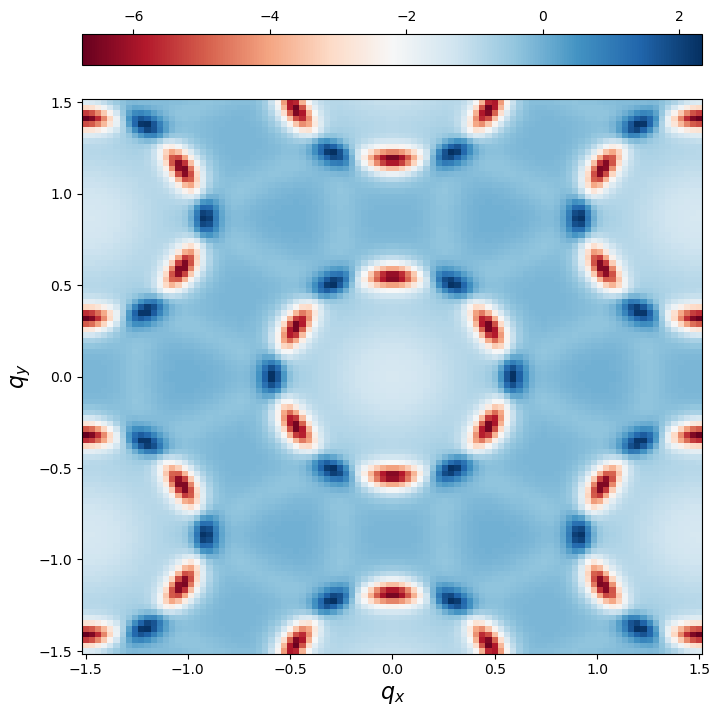

In [47]:
# set the relevant parameters
lambda = 1.5
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.1
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

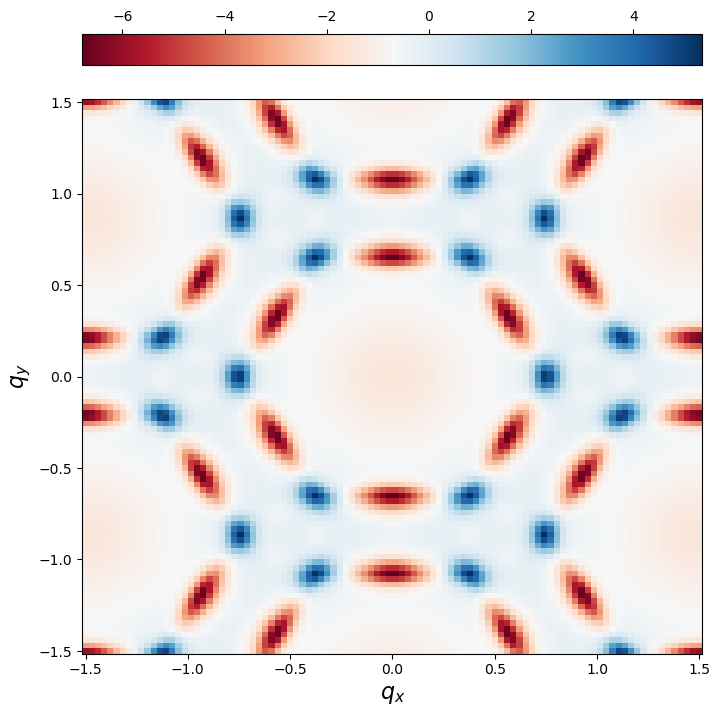

In [48]:
# set the relevant parameters
lambda = 1.5
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.75
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

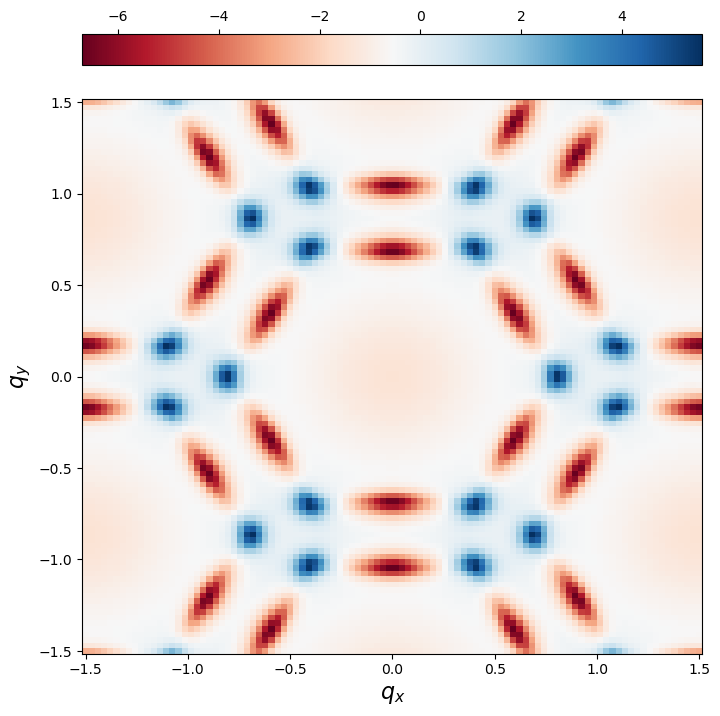

In [49]:
# set the relevant parameters
lambda = 1.5
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 1.5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

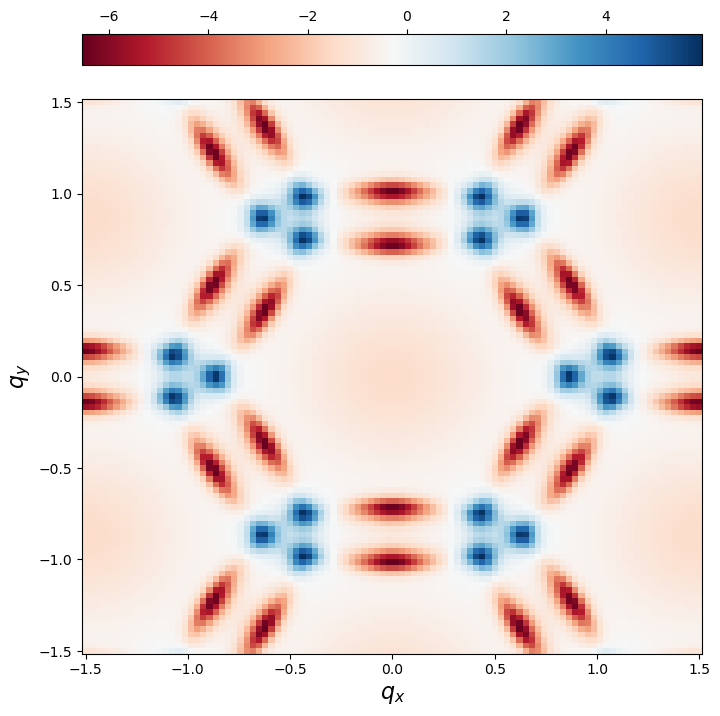

In [50]:
# set the relevant parameters
lambda = 1.5
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 3
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

### $\lambda = 3$

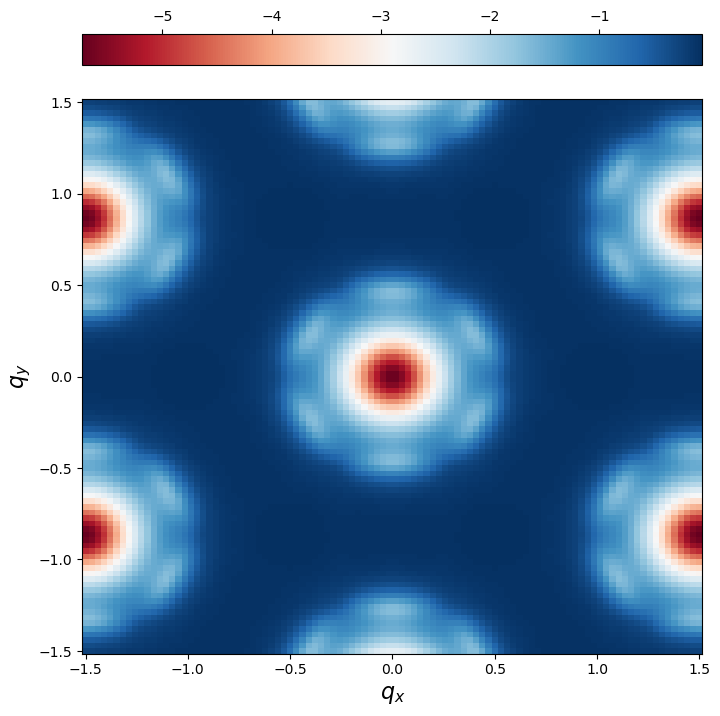

In [51]:
# set the relevant parameters
lambda = 3
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.1
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

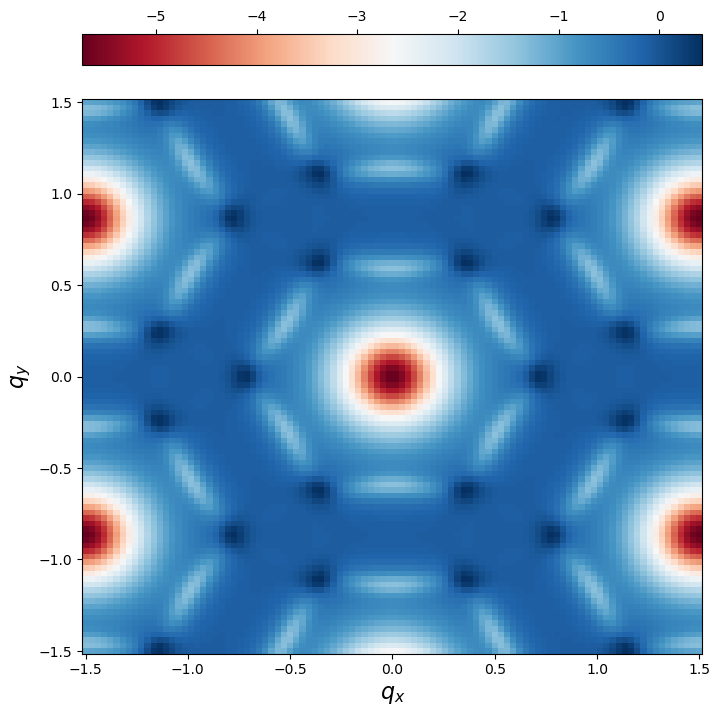

In [52]:
# set the relevant parameters
lambda = 3
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 0.75
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

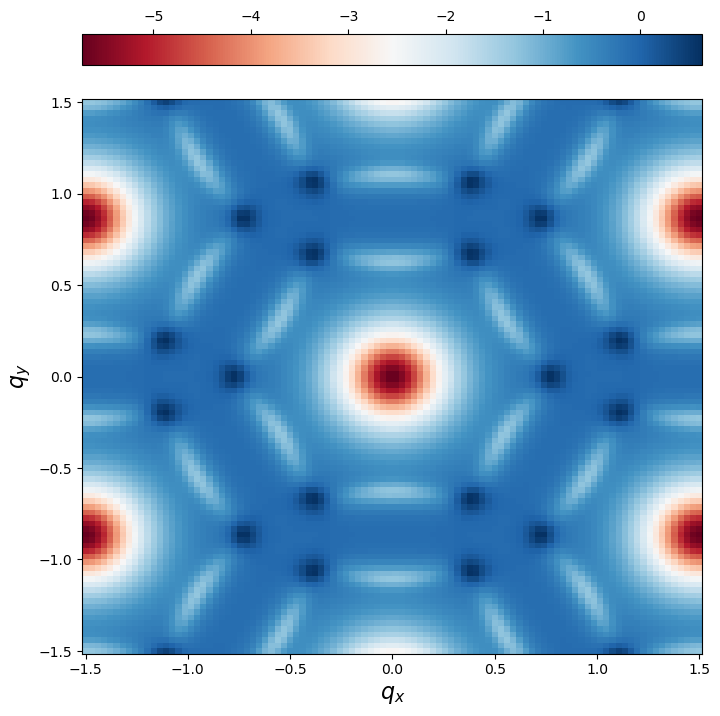

In [53]:
# set the relevant parameters
lambda = 3
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 1.5
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

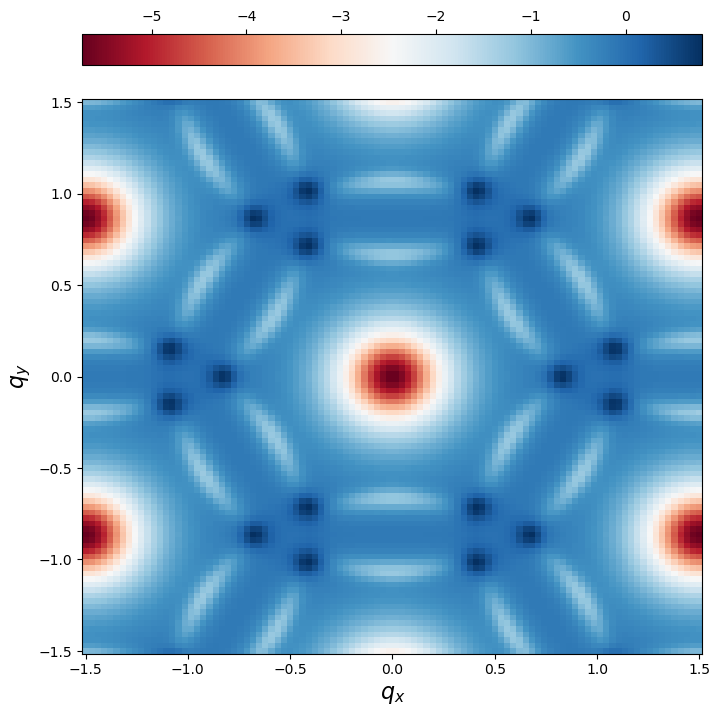

In [54]:
# set the relevant parameters
lambda = 3
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
vF = 3
index = 1
scale = 3/2
plotter_bc_v3(lambda, n, vF, gap, kappa, V, shells, index, bc_spacing, scale)

# Catalog version 2

In [24]:
function bc_save_data_n_disp(lambda, n, vF, gap, kappa, V, shells, index, spacing, n_pts, grid, filename)
    bc_list = grid_bc_v3(grid, lambda, n, gap, vF, kappa, V, shells, index, spacing)
    grid_new = reshape(grid, (n_pts, n_pts, 2))
    bc_list_new = reshape(bc_list, (n_pts, n_pts))

    data = Dict("grid" => grid_new, "berry" => bc_list_new, "lambda" => lambda, "n" => n, "vF" => vF, "gap" => gap, "kappa" => kappa, 
    "V" => V, "shells" => shells, "index" => index, "spacing" => spacing)

    @save filename data
end

function gen_file_name(lambda, n, vF, gap, kappa, V, shells, index, spacing)
    v1 = V[1, 1]
    v2 = V[2, 2]
    return "/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/notebooks/lambda_jellium/n_disp_bc_data/data_($lambda, $n, $vF, $v1, $v2).jld2"
end

function bc_data_gen(lambda, n, vF, gap, kappa, V, shells, index, spacing, scale, n_pts)
    k_list = scale * range(-kappa, kappa, n_pts)
    grid = mesh_grid(k_list, k_list, Float64)

    filename = gen_file_name(lambda, n, vF, gap, kappa, V, shells, index, spacing)

    bc_save_data_n_disp(lambda, n, vF, gap, kappa, V, shells, index, spacing, n_pts, grid, filename)
end

function batch_bc_data_gen(lambda_list, n_list, vF_list, gap, kappa, V, shells, index, spacing, scale, n_pts)
    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        for j in 1:length(n_list)
            n = n_list[j]
            for k in 1:length(vF_list)
                vF = vF_list[k]
                bc_data_gen(lambda, n, vF, gap, kappa, V, shells, index, spacing, scale, n_pts)
            end
        end
    end
end

batch_bc_data_gen (generic function with 1 method)

In [25]:
function bc_load_data(lambda, n, vF, gap, kappa, V, shells, index, spacing)
    filename = gen_file_name(lambda, n, vF, gap, kappa, V, shells, index, spacing)
    
    data = JLD2.load(filename)["data"]

    return data
end

function batch_bc_load_data(lambda_list, n_list, vF_list, gap, kappa, V, shells, index, spacing)
    data_set = []
    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        for j in 1:length(n_list)
            n = n_list[j]
            for k in 1:length(vF_list)
                vF = vF_list[k]
                data = bc_load_data(lambda, n, vF, gap, kappa, V, shells, index, spacing)
                push!(data_set, data)
            end
        end
    end
    return data_set
end

batch_bc_load_data (generic function with 1 method)

In [26]:
function batch_bc_plot_cb1(lambda_list, n, vF_list, gap, kappa, V, shells, index, spacing)
    n0 = Int(n/2)
    xdim = 8 * length(vF_list)
    ydim = 9 * length(lambda_list)
    fig, axs = plt.subplots(length(lambda_list), length(vF_list),figsize=(xdim, ydim))

    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        for j in 1:length(vF_list)
            vF = vF_list[j]
            data = bc_load_data(lambda, n, vF, gap, kappa, V, shells, index, spacing)
            grid = data["grid"]
            berry = data["berry"]

            bc_min = minimum(berry)
            bc_max = maximum(berry)
            bc_abs = maximum(abs.([bc_min, bc_max]))

            axs[i, j].set_xlabel(L"q_x", fontsize=16)
            axs[i, j].set_ylabel(L"q_y", fontsize=16)
            axs[i, j].set_title("\$(\\lambda, v_F, n) = ($(lambda), $(vF), $(n0)) \$", fontsize=16, pad=8)

            bc_plot = axs[i, j].pcolormesh(grid[:, :, 1], grid[:, :, 2], berry, cmap="RdBu", vmin = -bc_abs, vmax = bc_abs)

            cbar = fig.colorbar(bc_plot, orientation="horizontal", location="top", ax=axs[i, j])

        end
    end

    fig.tight_layout()
    fig
end

function batch_bc_plot_cb2(lambda_list, n, vF_list, gap, kappa, V, shells, index, spacing)
    n0 = Int(n/2)
    xdim = 8 * length(vF_list)
    ydim = 9 * length(lambda_list)
    fig, axs = plt.subplots(length(lambda_list), length(vF_list),figsize=(xdim, ydim))

    bc_max_val = 0

    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        for j in 1:length(vF_list)
            vF = vF_list[j]
            data = bc_load_data(lambda, n, vF, gap, kappa, V, shells, index, spacing)
            grid = data["grid"]
            berry = data["berry"]

            bc_min = minimum(berry)
            bc_max = maximum(berry)
            bc_abs = maximum(abs.([bc_min, bc_max]))

            if bc_abs > bc_max_val
                bc_max_val = bc_abs
            end

            axs[i, j].set_xlabel(L"q_x", fontsize=16)
            axs[i, j].set_ylabel(L"q_y", fontsize=16)
            axs[i, j].set_title("\$(\\lambda, v_F, n) = ($(lambda), $(vF), $(n0)) \$", fontsize=16, pad=8)
        end
    end

    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        for j in 1:length(vF_list)
            vF = vF_list[j]
            data = bc_load_data(lambda, n, vF, gap, kappa, V, shells, index, spacing)
            grid = data["grid"]
            berry = data["berry"]

            bc_plot = axs[i, j].pcolormesh(grid[:, :, 1], grid[:, :, 2], berry, cmap="RdBu", vmin = -bc_max_val, vmax = bc_max_val)
            if i == length(lambda_list) && j == length(vF_list)
                cbar_ax = fig.add_axes([0.15, 1.0, 0.7, 0.01])
                cbar = fig.colorbar(bc_plot, cax=cbar_ax, orientation="horizontal", location="top")
                cbar.ax.tick_params(labelsize=16)
            end
        end
    end

    fig.tight_layout()
    fig
end

batch_bc_plot_cb2 (generic function with 1 method)

In [27]:
function batch_bc_plot_cb1_chern(lambda_list, n, vF_list, gap, kappa, V, shells, index, spacing)
    n0 = Int(n/2)
    xdim = 8 * length(vF_list)
    ydim = 9 * length(lambda_list)
    fig, axs = plt.subplots(length(lambda_list), length(vF_list),figsize=(xdim, ydim))

    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        for j in 1:length(vF_list)
            vF = vF_list[j]
            data = bc_load_data(lambda, n, vF, gap, kappa, V, shells, index, spacing)
            grid = data["grid"]
            berry = data["berry"]

            chern_2 = C2_ev(n, gap, lambda, vF, kappa, V, shells)
            chern_3 = C3_ev(n, gap, lambda, vF, kappa, V, shells)

            chern = chern_mod_6(chern_2, chern_3)

            bc_min = minimum(berry)
            bc_max = maximum(berry)
            bc_abs = maximum(abs.([bc_min, bc_max]))

            axs[i, j].set_xlabel(L"q_x", fontsize=16)
            axs[i, j].set_ylabel(L"q_y", fontsize=16)
            axs[i, j].set_title("\$(\\lambda, v_F, n, C) = ($(lambda), $(vF), $(n0), $(chern)) \$", fontsize=16, pad=8)

            bc_plot = axs[i, j].pcolormesh(grid[:, :, 1], grid[:, :, 2], berry, cmap="RdBu", vmin = -bc_abs, vmax = bc_abs)

            cbar = fig.colorbar(bc_plot, orientation="horizontal", location="top", ax=axs[i, j])

        end
    end

    fig.tight_layout()
    fig
end
function batch_bc_plot_cb2_chern(lambda_list, n, vF_list, gap, kappa, V, shells, index, spacing)
    n0 = Int(n/2)
    xdim = 8 * length(vF_list)
    ydim = 9 * length(lambda_list)
    fig, axs = plt.subplots(length(lambda_list), length(vF_list),figsize=(xdim, ydim))

    bc_max_val = 0

    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        for j in 1:length(vF_list)
            vF = vF_list[j]
            data = bc_load_data(lambda, n, vF, gap, kappa, V, shells, index, spacing)
            grid = data["grid"]
            berry = data["berry"]

            chern_2 = C2_ev(n, gap, lambda, vF, kappa, V, shells)
            chern_3 = C3_ev(n, gap, lambda, vF, kappa, V, shells)

            chern = chern_mod_6(chern_2, chern_3)

            bc_min = minimum(berry)
            bc_max = maximum(berry)
            bc_abs = maximum(abs.([bc_min, bc_max]))

            if bc_abs > bc_max_val
                bc_max_val = bc_abs
            end

            axs[i, j].set_xlabel(L"q_x", fontsize=16)
            axs[i, j].set_ylabel(L"q_y", fontsize=16)
            axs[i, j].set_title("\$(\\lambda, v_F, n, C) = ($(lambda), $(vF), $(n0), $(chern)) \$", fontsize=16, pad=8)
        end
    end

    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        for j in 1:length(vF_list)
            vF = vF_list[j]
            data = bc_load_data(lambda, n, vF, gap, kappa, V, shells, index, spacing)
            grid = data["grid"]
            berry = data["berry"]

            bc_plot = axs[i, j].pcolormesh(grid[:, :, 1], grid[:, :, 2], berry, cmap="RdBu", vmin = -bc_max_val, vmax = bc_max_val)
            if i == length(lambda_list) && j == length(vF_list)
                cbar_ax = fig.add_axes([0.15, 1.0, 0.7, 0.01])
                cbar = fig.colorbar(bc_plot, cax=cbar_ax, orientation="horizontal", location="top")
                cbar.ax.tick_params(labelsize=16)
            end
        end
    end

    fig.tight_layout()
    fig
end

batch_bc_plot_cb2_chern (generic function with 1 method)

In [34]:
# set the relevant parameters
lambda_list = [0.1, 0.5, 0.8, 1.1, 1.5, 3]
n_list = [4]
vF_list = [0.1, 0.75, 1.5, 3]

kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
index = 1
scale = 3/2
n_pts = 100

# batch_bc_data_gen(lambda_list, n_list, vF_list, gap, kappa, V, shells, index, bc_spacing, scale, n_pts)

100

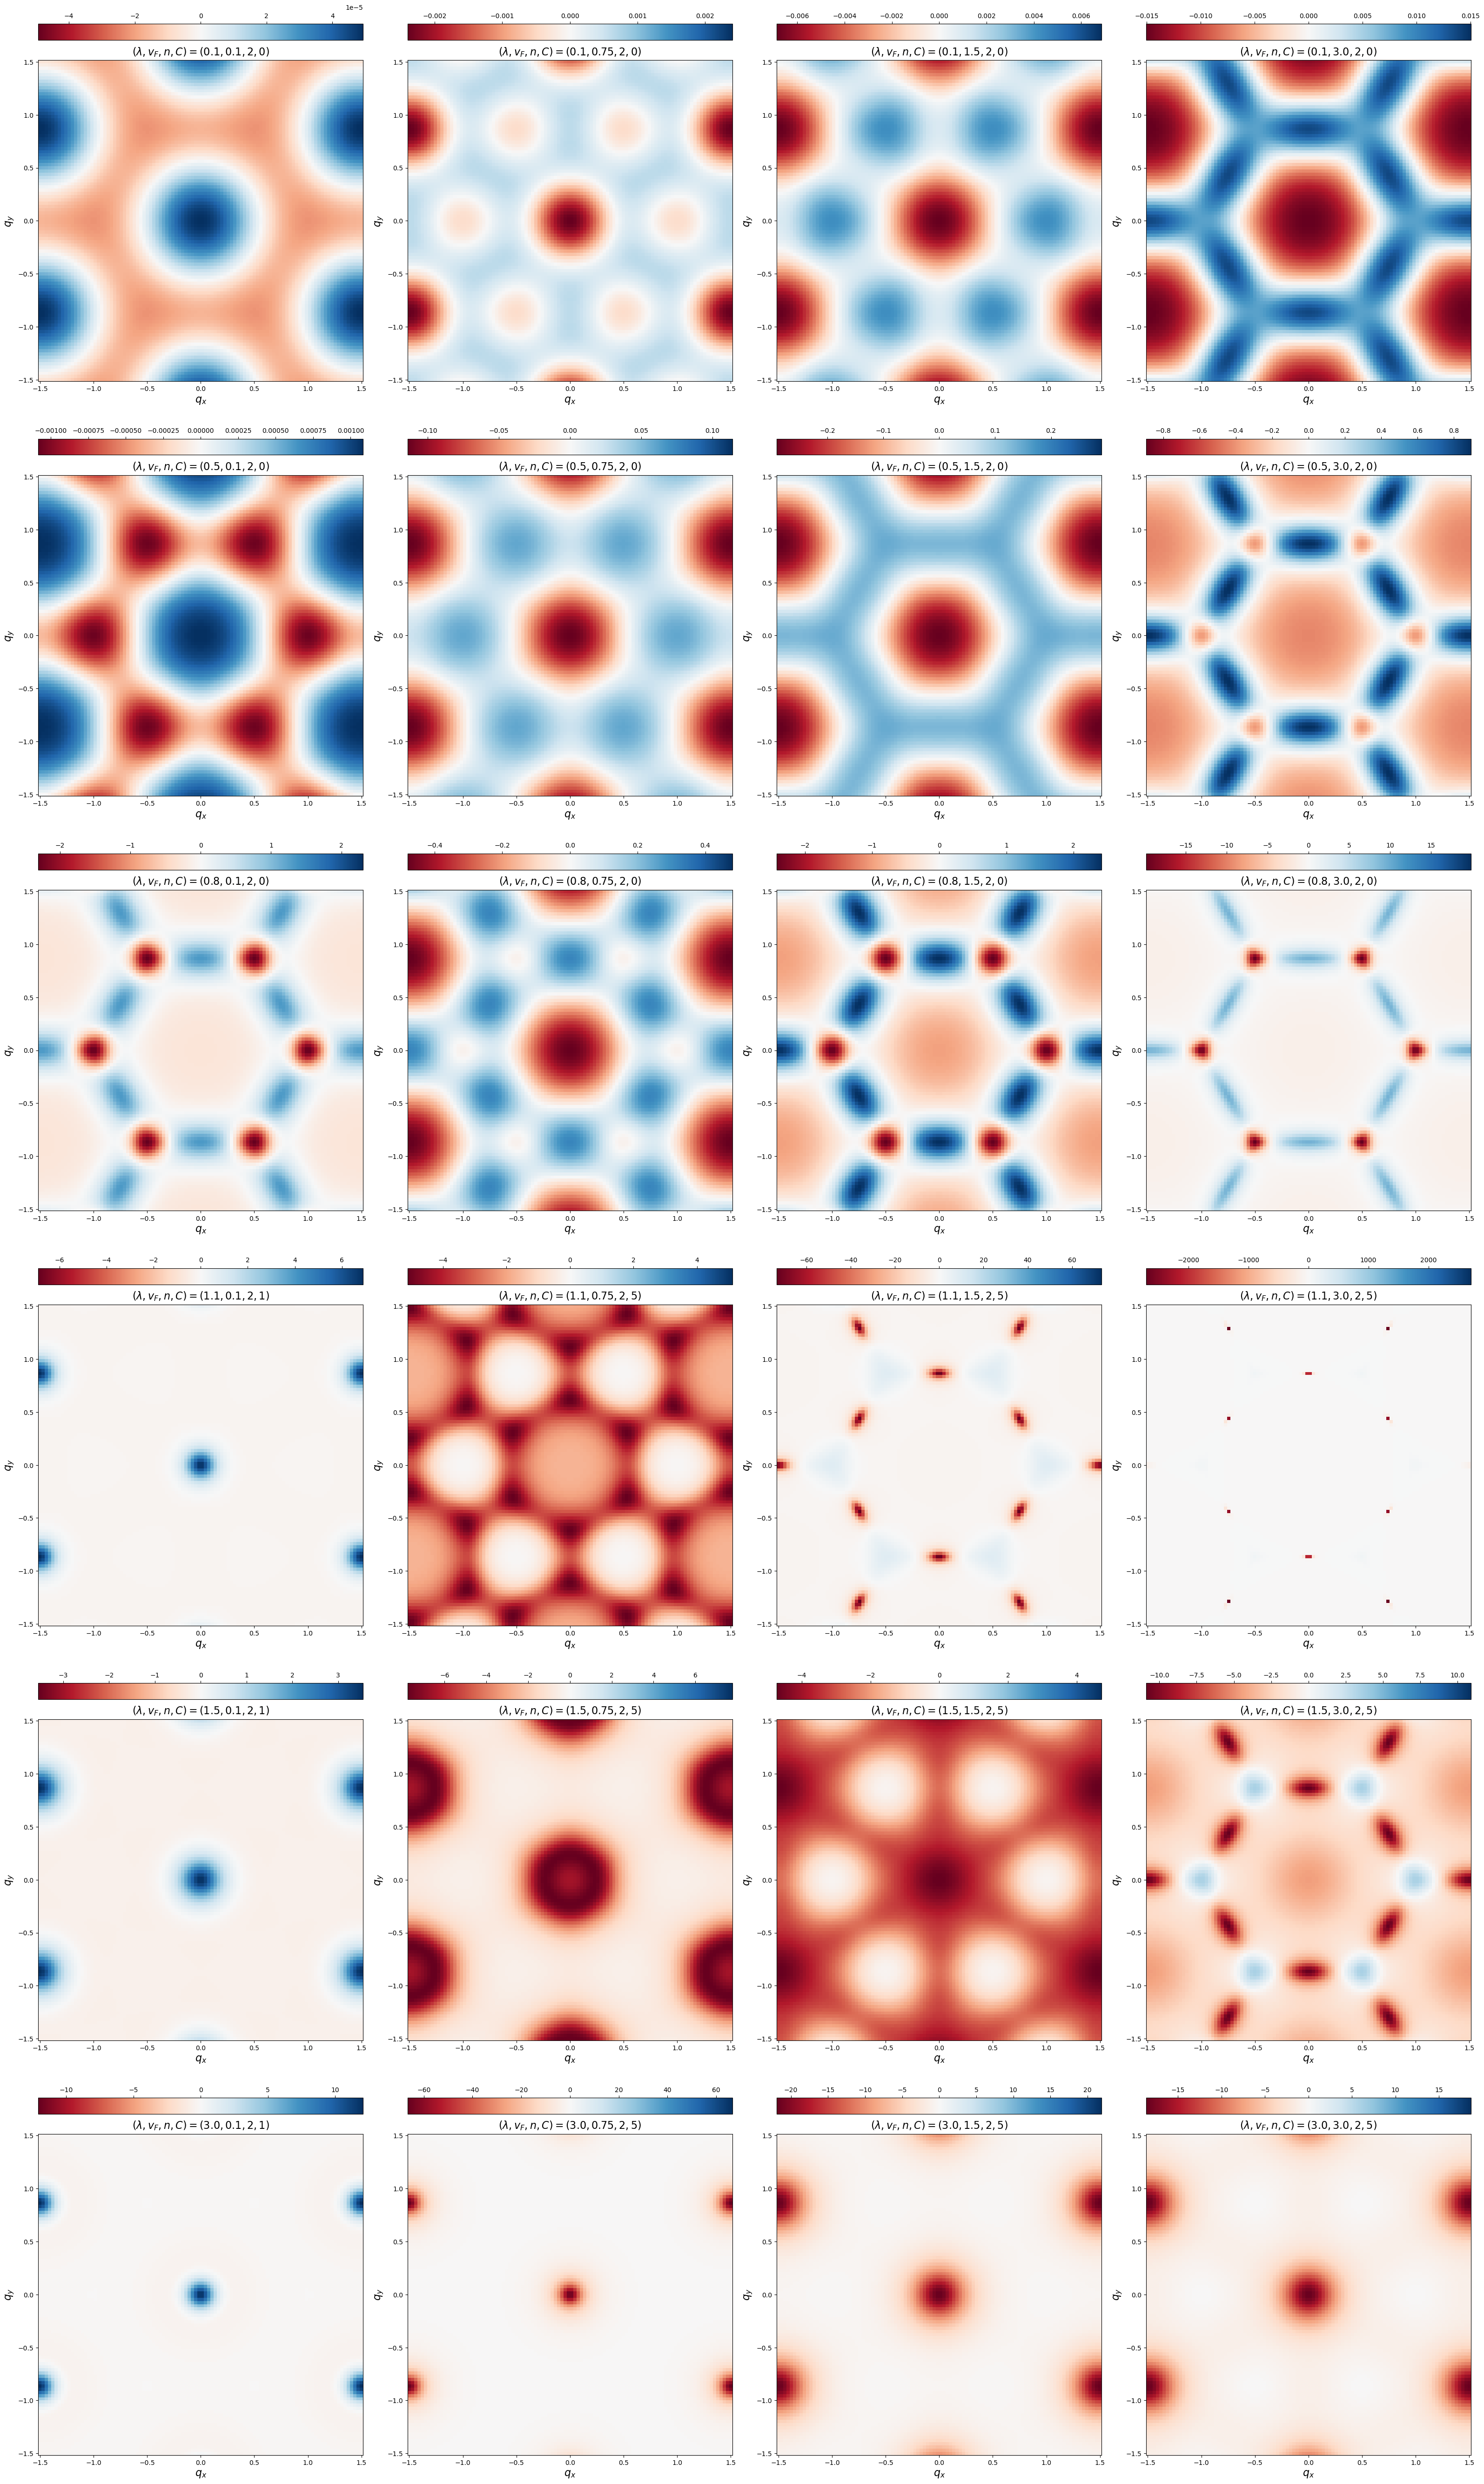

In [35]:
n = n_list[1]

batch_bc_plot_cb1_chern(lambda_list, n, vF_list, gap, kappa, V, shells, index, bc_spacing)